# **<font color="#ff006a">DISTRIBUTED DATA ANALYSIS AND MINING - PROJECT</font>**

By:
- Bruno Limón
- Rebecca Saitta
- Charlotte Brimont
- Giovanni Battista D’Orsi

---



# **<font color="#34ebdb">IMPORTS</font>**

In [3]:
# For Colab
# Install packages:
# !pip install pyspark
# !pip install sparknlp

# Or, setup pyspark environment
!wget http://setup.johnsnowlabs.com/colab.sh -O - | bash

--2022-12-16 19:12:47--  http://setup.johnsnowlabs.com/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://setup.johnsnowlabs.com/colab.sh [following]
--2022-12-16 19:12:47--  https://setup.johnsnowlabs.com/colab.sh
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh [following]
--2022-12-16 19:12:48--  https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [55]:
# General
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
np.set_printoptions(suppress=True) # to avoid scientific notation while printing

from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
from datetime import datetime
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, precision_recall_curve, average_precision_score, roc_auc_score

# Spark
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import FloatType

# Preprocessing
from pyspark.sql.functions import *
from pyspark.ml.stat import Correlation
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import CountVectorizer, VectorAssembler, StringIndexer, RegexTokenizer, StopWordsRemover, OneHotEncoder

# Clustering
from pyspark.ml.clustering import LDA, KMeans, BisectingKMeans
from pyspark.ml.feature import PCA as PCAml, HashingTF, IDF

# Classification
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier, LinearSVC, LinearSVCSummary

# Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator, ClusteringEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

# Tuning
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Frequent Pattern Mining
from pyspark.ml.fpm import FPGrowth

In [5]:
# For Colab, mount drive, making sure to have the files as a shortcut in your main drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **<font color="#34ebdb">1.0 DATA UNDERSTANDING & PREPROCESSING</font>**

In [6]:
# Initialize a new Spark Session
sc = SparkContext(appName="DDAM_Group6_context", master="local[*]")

spark = SparkSession.builder \
     .master('local[*]') \
     .appName('DDAM_Group6_session') \
     .getOrCreate()

sqlContext = SQLContext(spark)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:77: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [7]:
# Choose between colab or local path
path = '/content/drive/MyDrive/' # Colab
# path = 'Data/'                 # local

## **<font color="#FBBF44">1.1 FAKE DATASET</font>**

In [8]:
# loading the fake dataset
fake_data = spark.read.format("csv") .options(header='true', 
             multiLine = 'True',
             inferschema='true', 
             treatEmptyValuesAsNulls='true',
             escape='\"').load(path + 'Fake.csv')

print(fake_data.printSchema())
print(fake_data.count())
fake_data.show(5)

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)

None
23471
+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|
+--------------------+--------------------+-------+-----------------+
only showing top 5 rows



In [9]:
#see if we have only unique titles and texts
print('nb unique title:', fake_data.select('title').distinct().count())
print('nb unique text:', fake_data.select('text').distinct().count())
print('nb rows:', fake_data.count())

nb unique title: 17897
nb unique text: 17449
nb rows: 23471


In [10]:
# Looking at the distinct values in 'subject' from fake news
fake_data.select('subject').distinct().collect()

[Row(subject='US_News'),
 Row(subject='left-news'),
 Row(subject='politics'),
 Row(subject='Government News'),
 Row(subject='Middle-east'),
 Row(subject='News')]

In [11]:
# Collecting contents of dataset to see a full example of the text column
print(fake_data.collect()[0].__getitem__('text'))

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

## **<font color="#FBBF44">1.1 TRUE DATASET</font>**

In [12]:
# loading the true dataset
true_data = spark.read.format("csv") .options(header='true', 
             multiLine = 'True',
             inferschema='true', 
             treatEmptyValuesAsNulls='true',
             escape='\"').load(path + 'True.csv')

print(true_data.printSchema())
print(true_data.count())
true_data.show(5)

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)

None
21417
+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|FBI Russia probe ...|WASHINGTON (Reute...|politicsNews|December 30, 2017 |
|Trump wants Posta...|SEATTLE/WASHINGTO...|politicsNews|December 29, 2017 |
+--------------------+--------------------+------------+------------------+
only showing top 5 rows



In [13]:
#see if we have only unique titles and texts
print('nb unique title:', true_data.select('title').distinct().count())
print('nb unique text:', true_data.select('text').distinct().count())
print('nb rows:', true_data.count())

nb unique title: 20826
nb unique text: 21192
nb rows: 21417


In [14]:
# Looking at the distinct values in 'subject'
print(true_data.select('subject').distinct().collect())

[Row(subject='worldnews'), Row(subject='politicsNews')]


In [15]:
# Collecting contents of dataset to see an example of text column
print(true_data.collect()[0].__getitem__('title'))

As U.S. budget fight looms, Republicans flip their fiscal script


## **<font color="#FBBF44">1.3 FULL DATASET</font>**

In [16]:
# Adding a 'fake' column to specify the label of the record when combining both datasets
fake_data = fake_data.withColumn("fake", lit(1))
true_data = true_data.withColumn("fake", lit(0))

# Putting both datasets together and looking at an overview of them
full_data = fake_data.union(true_data)
print(full_data.printSchema())
print(full_data.count())
full_data.show(5)

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)
 |-- fake: integer (nullable = false)

None
44888
+--------------------+--------------------+-------+-----------------+----+
|               title|                text|subject|             date|fake|
+--------------------+--------------------+-------+-----------------+----+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|   1|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|   1|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|   1|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|   1|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|   1|
+--------------------+--------------------+-------+-----------------+----+
only showing top 5 rows



In [17]:
# Looking at the distinct values in 'subject' for the full dataset
full_data.select('subject').distinct().collect()

[Row(subject='US_News'),
 Row(subject='left-news'),
 Row(subject='politics'),
 Row(subject='Government News'),
 Row(subject='Middle-east'),
 Row(subject='News'),
 Row(subject='worldnews'),
 Row(subject='politicsNews')]

In [18]:
# Brief overview of data
full_data.describe().show()

+-------+--------------------+--------------------+---------------+------------------+-------------------+
|summary|               title|                text|        subject|              date|               fake|
+-------+--------------------+--------------------+---------------+------------------+-------------------+
|  count|               44888|               44888|          44888|             44888|              44888|
|   mean|                null|                null|           null|              null| 0.5228791659240777|
| stddev|                null|                null|           null|              null|0.49948183314938155|
|    min|\r\r\r\r\r\r\nDon...|                    |Government News|         14-Feb-18|                  0|
|    max|“You’re Not Welco...|youngers these da...|      worldnews|September 9, 2017 |                  1|
+-------+--------------------+--------------------+---------------+------------------+-------------------+



In [19]:
# Looking for Nulls and NaNs
full_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in full_data.columns]).show()

+-----+----+-------+----+----+
|title|text|subject|date|fake|
+-----+----+-------+----+----+
|    0|   0|      0|   0|   0|
+-----+----+-------+----+----+



In [20]:
# Creating view to query from
full_data.createOrReplaceTempView("view")

# Query to get total number of elements for each category
total_subject = sqlContext.sql("""SELECT subject, COUNT(*) as total 
                                    FROM view 
                                    GROUP BY subject 
                                    ORDER BY total desc""")

# Query to get total number of elements for each label
total_label = sqlContext.sql("""SELECT fake, COUNT(*) as total 
                                    FROM view 
                                    GROUP BY fake 
                                    ORDER BY total desc""")

# Query to get total number of elements for each subject, divided by label
total_subject_label = sqlContext.sql("""SELECT subject, COUNT(*) as total, sum(fake) as fake, COUNT(*) - sum(fake) as true
                                    FROM view 
                                    GROUP BY subject, fake 
                                    ORDER BY total desc""")

print(total_subject.show())
print(total_label.show())
print(total_subject_label.show())

# Passing spark DF to pandas DF to plot more easily later
total_subject = total_subject.toPandas()
total_label = total_label.toPandas()

+---------------+-----+
|        subject|total|
+---------------+-----+
|   politicsNews|11272|
|      worldnews|10145|
|           News| 9050|
|       politics| 6836|
|      left-news| 4456|
|Government News| 1568|
|        US_News|  783|
|    Middle-east|  778|
+---------------+-----+

None
+----+-----+
|fake|total|
+----+-----+
|   1|23471|
|   0|21417|
+----+-----+

None
+---------------+-----+----+-----+
|        subject|total|fake| true|
+---------------+-----+----+-----+
|   politicsNews|11272|   0|11272|
|      worldnews|10145|   0|10145|
|           News| 9050|9050|    0|
|       politics| 6836|6836|    0|
|      left-news| 4456|4456|    0|
|Government News| 1568|1568|    0|
|        US_News|  783| 783|    0|
|    Middle-east|  778| 778|    0|
+---------------+-----+----+-----+

None


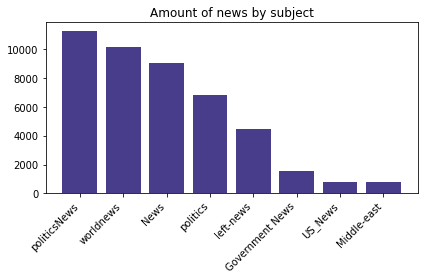

In [21]:
# News by subject
plt.bar(total_subject['subject'], total_subject['total'], color='darkslateblue') 
plt.title("Amount of news by subject")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('SubjectBefore.png', dpi=600) 
plt.show()

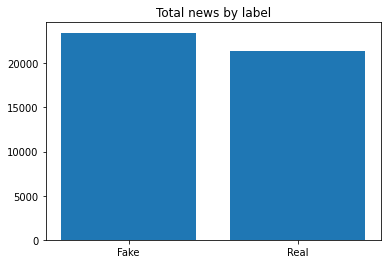

In [22]:
# News by label
plt.bar(['Fake','Real'], total_label['total']) 
plt.title("Total news by label")
plt.show()

## **<font color="#FBBF44">1.4 PREPROCESSING</font>**

### **<font color="#7dfa75">1.4.1 SUBJECT & DATE</font>**

**<font color="#ffff7">SUBJECT</font>**

Since "worldnews" and "politicsNews" are subjects that appear only on the "True" dataset, in order to avoid bias we decided to transorm them into subjects already appearing in the "Fake" dataset, transforming "worldnews" into "news" and "politicsnews" into "politics", expecting them to match just fine

In [23]:
# Using regex_replace to transform the subjects
full_data_pre = full_data.withColumn("subject",regexp_replace(col('subject'), 'worldnews', 'News')) \
               .withColumn("subject",regexp_replace(col('subject'), 'politicsNews', 'politics'))
full_data_pre.show(5)

+--------------------+--------------------+-------+-----------------+----+
|               title|                text|subject|             date|fake|
+--------------------+--------------------+-------+-----------------+----+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|   1|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|   1|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|   1|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|   1|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|   1|
+--------------------+--------------------+-------+-----------------+----+
only showing top 5 rows



In [24]:
# Confirming the undesired subjects are no longer present in the dataset
full_data_pre.select('subject').distinct().collect()

[Row(subject='US_News'),
 Row(subject='left-news'),
 Row(subject='politics'),
 Row(subject='Government News'),
 Row(subject='Middle-east'),
 Row(subject='News')]

In [25]:
# Querying again for the total amount of records with each subject, we can now see the difference in "News" and "Politics"
full_data_pre.createOrReplaceTempView("view")
total_subject = sqlContext.sql("""SELECT subject, COUNT(*) as total 
                                    FROM view 
                                    GROUP BY subject 
                                    ORDER BY total desc""")
print(total_subject.show())
total_subject = total_subject.toPandas()

+---------------+-----+
|        subject|total|
+---------------+-----+
|           News|19195|
|       politics|18108|
|      left-news| 4456|
|Government News| 1568|
|        US_News|  783|
|    Middle-east|  778|
+---------------+-----+

None


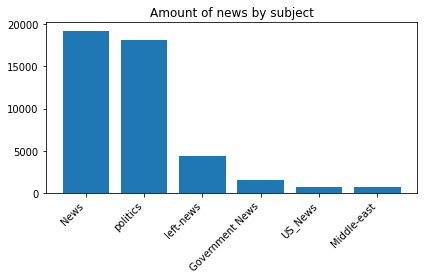

In [26]:
# News by subject
plt.bar(total_subject['subject'], total_subject['total']) 
plt.title("Amount of news by subject")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('SubjectAfter.png', dpi=600)
plt.show()

**<font color="#ffff7">DATE</font>**

Regarding "Date", the idea is to have a consistent and accessible format to use for analysis. As of now, there are seem to be different formats present in the dataset, like full months and abbreviated ones, which can complicate their use.

In [27]:
# 1st step is to remove the comma from the date
data_date = full_data_pre.withColumn("date",regexp_replace(col('date'), ',', ''))

# Then splitting each element into its respective column
data_date = data_date.withColumn('year', split(data_date['date'], ' ').getItem(2)) \
                     .withColumn('month', split(data_date['date'], ' ').getItem(0)) \
                     .withColumn('day', split(data_date['date'], ' ').getItem(1))
print(data_date.show(1))

# Tranforming abbreviated months, e.g. "Dec" into their full form, "December", then taking this full form into a number, "12"
data_date = data_date.withColumn('month', when((length(data_date.month) > 3) | (data_date.month == "May"), data_date.month)
                     .otherwise(from_unixtime(unix_timestamp(data_date.month,'MMM'),'MMMM'))) \
                     .withColumn("month",from_unixtime(unix_timestamp(col("month"),'MMMM'),'MM'))
print(data_date.show(1))

+--------------------+--------------------+-------+----------------+----+----+--------+---+
|               title|                text|subject|            date|fake|year|   month|day|
+--------------------+--------------------+-------+----------------+----+----+--------+---+
| Donald Trump Sen...|Donald Trump just...|   News|December 31 2017|   1|2017|December| 31|
+--------------------+--------------------+-------+----------------+----+----+--------+---+
only showing top 1 row

None
+--------------------+--------------------+-------+----------------+----+----+-----+---+
|               title|                text|subject|            date|fake|year|month|day|
+--------------------+--------------------+-------+----------------+----+----+-----+---+
| Donald Trump Sen...|Donald Trump just...|   News|December 31 2017|   1|2017|   12| 31|
+--------------------+--------------------+-------+----------------+----+----+-----+---+
only showing top 1 row

None


In [28]:
# Looking for Nulls and NaNs before producing the final output for date, to see if anything went wrong
data_date.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_date.columns]).show()
data_date.filter(col("month").isNull()).show(5)

+-----+----+-------+----+----+----+-----+---+
|title|text|subject|date|fake|year|month|day|
+-----+----+-------+----+----+----+-----+---+
|    0|   0|      0|   0|   0|  35|   35| 35|
+-----+----+-------+----+----+----+-----+---+

+--------------------+--------------------+--------+---------+----+----+-----+----+
|               title|                text| subject|     date|fake|year|month| day|
+--------------------+--------------------+--------+---------+----+----+-----+----+
|Democrat Senator ...|According to The ...|politics|19-Feb-18|   1|null| null|null|
|MSNBC ANCHOR Flab...|If we protect eve...|politics|19-Feb-18|   1|null| null|null|
|WATCH: SNOWFLAKES...|Ami Horowitz is f...|politics|19-Feb-18|   1|null| null|null|
|JUST IN: BADASS G...|Just one more rem...|politics|18-Feb-18|   1|null| null|null|
|DOJ’s JEFF SESSIO...|Thank goodnesss J...|politics|18-Feb-18|   1|null| null|null|
+--------------------+--------------------+--------+---------+----+----+-----+----+
only showing 

In [29]:
# Indeed, the previous cell shows us that 35 rows got NULL values, this due to a 3rd and unexpected format, a numerical one
# Given the small amount of them and for simplicity, dropping the rows is the chosen approach
data_date = data_date.dropna()
data_date.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data_date.columns]).show()

+-----+----+-------+----+----+----+-----+---+
|title|text|subject|date|fake|year|month|day|
+-----+----+-------+----+----+----+-----+---+
|    0|   0|      0|   0|   0|   0|    0|  0|
+-----+----+-------+----+----+----+-----+---+



In [30]:
# Finalizing the date preprocessing by putting together the values into their final column
data_date = data_date.select('title','text','subject', 
                             concat_ws('-',data_date.year,data_date.month,data_date.day).alias("date"),
                             'fake')
print(data_date.show(5))

+--------------------+--------------------+-------+----------+----+
|               title|                text|subject|      date|fake|
+--------------------+--------------------+-------+----------+----+
| Donald Trump Sen...|Donald Trump just...|   News|2017-12-31|   1|
| Drunk Bragging T...|House Intelligenc...|   News|2017-12-31|   1|
| Sheriff David Cl...|On Friday, it was...|   News|2017-12-30|   1|
| Trump Is So Obse...|On Christmas day,...|   News|2017-12-29|   1|
| Pope Francis Jus...|Pope Francis used...|   News|2017-12-25|   1|
+--------------------+--------------------+-------+----------+----+
only showing top 5 rows

None


### **<font color="#7dfa75">1.4.2 PREPARING FOR NLP</font>**

In [31]:
# Removing numbers and symbols to remain only with words
data_nlp = data_date

for col_name in ["title", "text"]:
    data_nlp = data_nlp.withColumn(col_name,regexp_replace(col(col_name), '\d+', ''))

data_nlp.select('text').show(1, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
# Tokenizer
for col_name in ["title", "text"]:
  regex_tokenizer = RegexTokenizer(inputCol=col_name, outputCol=col_name+"Token", pattern="\\W")
  data_nlp = regex_tokenizer.transform(data_nlp)

# Adding id to keep track of records later on
data_nlp = data_nlp.withColumn("id", monotonically_increasing_id())

data_nlp = data_nlp.select('id', 'titleToken', 'textToken', 'subject', 'date', 'fake')
data_nlp.show(5)

+---+--------------------+--------------------+-------+----------+----+
| id|          titleToken|           textToken|subject|      date|fake|
+---+--------------------+--------------------+-------+----------+----+
|  0|[donald, trump, s...|[donald, trump, j...|   News|2017-12-31|   1|
|  1|[drunk, bragging,...|[house, intellige...|   News|2017-12-31|   1|
|  2|[sheriff, david, ...|[on, friday, it, ...|   News|2017-12-30|   1|
|  3|[trump, is, so, o...|[on, christmas, d...|   News|2017-12-29|   1|
|  4|[pope, francis, j...|[pope, francis, u...|   News|2017-12-25|   1|
+---+--------------------+--------------------+-------+----------+----+
only showing top 5 rows



In [33]:
# Removing stopwords
for col_name in ["titleToken", "textToken"]:
  remover = StopWordsRemover(inputCol=col_name, outputCol=col_name+"s")
  data_nlp = remover.transform(data_nlp)

data_nlp = data_nlp.select('id', 'titleTokens', 'textTokens', 'subject', 'date', 'fake')
(data_nlp.select('titleTokens').collect()[0][0])[0:10]

['donald',
 'trump',
 'sends',
 'embarrassing',
 'new',
 'year',
 'eve',
 'message',
 'disturbing']

In [34]:
# Turning subject strings into numeric values, to later apply one hot encoding
indexer = StringIndexer(inputCol='subject', outputCol='numericSubject')
indexer_model = indexer.fit(data_nlp)
data_nlp_vec = indexer_model.transform(data_nlp)

# Applying one-hot encoding to turn categorical values in subject into a vector representing the diferent categories
OHE = OneHotEncoder(inputCol="numericSubject", outputCol="subject_vec", dropLast=False)
OHE_model = OHE.fit(data_nlp_vec)
data_nlp_vec = OHE_model.transform(data_nlp_vec).select('id',"titleTokens","textTokens","subject_vec","date","fake")
data_nlp_vec.show(5)

+---+--------------------+--------------------+-------------+----------+----+
| id|         titleTokens|          textTokens|  subject_vec|      date|fake|
+---+--------------------+--------------------+-------------+----------+----+
|  0|[donald, trump, s...|[donald, trump, c...|(6,[0],[1.0])|2017-12-31|   1|
|  1|[drunk, bragging,...|[house, intellige...|(6,[0],[1.0])|2017-12-31|   1|
|  2|[sheriff, david, ...|[friday, revealed...|(6,[0],[1.0])|2017-12-30|   1|
|  3|[trump, obsessed,...|[christmas, day, ...|(6,[0],[1.0])|2017-12-29|   1|
|  4|[pope, francis, c...|[pope, francis, u...|(6,[0],[1.0])|2017-12-25|   1|
+---+--------------------+--------------------+-------------+----------+----+
only showing top 5 rows



In [35]:
# In order to vectorize the date column, it is first split and put into separate columns
data_nlp_vec = data_nlp_vec.withColumn("date",regexp_replace(col('date'), '-', ' '))
data_nlp_vec = data_nlp_vec.withColumn('year', split(data_nlp_vec['date'], ' ').getItem(0)) \
                     .withColumn('month', split(data_nlp_vec['date'], ' ').getItem(1)) \
                     .withColumn('day', split(data_nlp_vec['date'], ' ').getItem(2))

# Casting as int to feed into VectorAssembler later on to vectorize
data_nlp_vec = data_nlp_vec.withColumn("year",col("year").cast('int')) \
                           .withColumn("month",col("month").cast('int')) \
                           .withColumn("day",col("day").cast('int'))
data_nlp_vec.show(5)

+---+--------------------+--------------------+-------------+----------+----+----+-----+---+
| id|         titleTokens|          textTokens|  subject_vec|      date|fake|year|month|day|
+---+--------------------+--------------------+-------------+----------+----+----+-----+---+
|  0|[donald, trump, s...|[donald, trump, c...|(6,[0],[1.0])|2017 12 31|   1|2017|   12| 31|
|  1|[drunk, bragging,...|[house, intellige...|(6,[0],[1.0])|2017 12 31|   1|2017|   12| 31|
|  2|[sheriff, david, ...|[friday, revealed...|(6,[0],[1.0])|2017 12 30|   1|2017|   12| 30|
|  3|[trump, obsessed,...|[christmas, day, ...|(6,[0],[1.0])|2017 12 29|   1|2017|   12| 29|
|  4|[pope, francis, c...|[pope, francis, u...|(6,[0],[1.0])|2017 12 25|   1|2017|   12| 25|
+---+--------------------+--------------------+-------------+----------+----+----+-----+---+
only showing top 5 rows



In [36]:
# Constructing the vector from the data obtained before
assembler = VectorAssembler(inputCols=['year','month','day'], outputCol="date_vec")
data_nlp_vec = assembler.transform(data_nlp_vec).select('id','titleTokens','textTokens','subject_vec','date_vec','fake')
data_nlp_vec.show(5)

+---+--------------------+--------------------+-------------+------------------+----+
| id|         titleTokens|          textTokens|  subject_vec|          date_vec|fake|
+---+--------------------+--------------------+-------------+------------------+----+
|  0|[donald, trump, s...|[donald, trump, c...|(6,[0],[1.0])|[2017.0,12.0,31.0]|   1|
|  1|[drunk, bragging,...|[house, intellige...|(6,[0],[1.0])|[2017.0,12.0,31.0]|   1|
|  2|[sheriff, david, ...|[friday, revealed...|(6,[0],[1.0])|[2017.0,12.0,30.0]|   1|
|  3|[trump, obsessed,...|[christmas, day, ...|(6,[0],[1.0])|[2017.0,12.0,29.0]|   1|
|  4|[pope, francis, c...|[pope, francis, u...|(6,[0],[1.0])|[2017.0,12.0,25.0]|   1|
+---+--------------------+--------------------+-------------+------------------+----+
only showing top 5 rows



In [37]:
# Using CountVectorizer, to transform the title and contents of the news articles into vectors that represent their features
for col_name in ["titleTokens", "textTokens"]:
  count_vectorizer = CountVectorizer(inputCol=col_name, outputCol=col_name+'_vecfull')
  cv_model = count_vectorizer.fit(data_nlp_vec)
  data_nlp_vec = cv_model.transform(data_nlp_vec)

data_nlp_vec_fullfeatures = data_nlp_vec.select('id',"titleTokens_vecfull","textTokens_vecfull","subject_vec","date_vec","fake")
  
for col_name in ["titleTokens", "textTokens"]:
  count_vectorizer = CountVectorizer(inputCol=col_name, outputCol=col_name+'_vec', minDF=.01, maxDF=.9)
  cv_model = count_vectorizer.fit(data_nlp_vec)
  data_nlp_vec = cv_model.transform(data_nlp_vec)

data_nlp_vec = data_nlp_vec.select('id',"titleTokens_vec","textTokens_vec","subject_vec","date_vec","fake")
data_nlp_vec.show(5)

+---+--------------------+--------------------+-------------+------------------+----+
| id|     titleTokens_vec|      textTokens_vec|  subject_vec|          date_vec|fake|
+---+--------------------+--------------------+-------------+------------------+----+
|  0|(88,[0,9,24],[1.0...|(3024,[0,2,4,5,7,...|(6,[0],[1.0])|[2017.0,12.0,31.0]|   1|
|  1|(88,[0,43],[1.0,1...|(3024,[0,1,2,8,10...|(6,[0],[1.0])|[2017.0,12.0,31.0]|   1|
|  2|     (88,[51],[1.0])|(3024,[0,4,5,12,1...|(6,[0],[1.0])|[2017.0,12.0,30.0]|   1|
|  3|(88,[0,4],[1.0,1.0])|(3024,[0,2,4,7,11...|(6,[0],[1.0])|[2017.0,12.0,29.0]|   1|
|  4|(88,[0,24,64],[1....|(3024,[0,1,4,5,12...|(6,[0],[1.0])|[2017.0,12.0,25.0]|   1|
+---+--------------------+--------------------+-------------+------------------+----+
only showing top 5 rows



In [38]:
# Putting together all previous vectors into a final one
assembler = VectorAssembler(inputCols=['titleTokens_vecfull',
                                       'textTokens_vecfull',
                                       'subject_vec',
                                       'date_vec'], 
                            outputCol="full_features")
data_nlp_vec_fullfeatures = assembler.transform(data_nlp_vec_fullfeatures).select('id','titleTokens_vecfull','textTokens_vecfull','subject_vec','date_vec','full_features','fake')

assembler = VectorAssembler(inputCols=['titleTokens_vec',
                                       'textTokens_vec',
                                       'subject_vec',
                                       'date_vec'], 
                            outputCol="full_features")
data_nlp_vec = assembler.transform(data_nlp_vec).select('id','titleTokens_vec','textTokens_vec','subject_vec','date_vec','full_features','fake')
data_nlp_vec.show(5)

+---+--------------------+--------------------+-------------+------------------+--------------------+----+
| id|     titleTokens_vec|      textTokens_vec|  subject_vec|          date_vec|       full_features|fake|
+---+--------------------+--------------------+-------------+------------------+--------------------+----+
|  0|(88,[0,9,24],[1.0...|(3024,[0,2,4,5,7,...|(6,[0],[1.0])|[2017.0,12.0,31.0]|(3121,[0,9,24,88,...|   1|
|  1|(88,[0,43],[1.0,1...|(3024,[0,1,2,8,10...|(6,[0],[1.0])|[2017.0,12.0,31.0]|(3121,[0,43,88,89...|   1|
|  2|     (88,[51],[1.0])|(3024,[0,4,5,12,1...|(6,[0],[1.0])|[2017.0,12.0,30.0]|(3121,[51,88,92,9...|   1|
|  3|(88,[0,4],[1.0,1.0])|(3024,[0,2,4,7,11...|(6,[0],[1.0])|[2017.0,12.0,29.0]|(3121,[0,4,88,90,...|   1|
|  4|(88,[0,24,64],[1....|(3024,[0,1,4,5,12...|(6,[0],[1.0])|[2017.0,12.0,25.0]|(3121,[0,24,64,88...|   1|
+---+--------------------+--------------------+-------------+------------------+--------------------+----+
only showing top 5 rows



In [39]:
data_nlp_vec_fullfeatures.show(5)

+---+--------------------+--------------------+-------------+------------------+--------------------+----+
| id| titleTokens_vecfull|  textTokens_vecfull|  subject_vec|          date_vec|       full_features|fake|
+---+--------------------+--------------------+-------------+------------------+--------------------+----+
|  0|(20311,[0,9,24,10...|(114671,[0,2,4,5,...|(6,[0],[1.0])|[2017.0,12.0,31.0]|(134991,[0,9,24,1...|   1|
|  1|(20311,[0,43,278,...|(114671,[0,1,2,8,...|(6,[0],[1.0])|[2017.0,12.0,31.0]|(134991,[0,43,278...|   1|
|  2|(20311,[51,472,81...|(114671,[0,4,5,12...|(6,[0],[1.0])|[2017.0,12.0,30.0]|(134991,[51,472,8...|   1|
|  3|(20311,[0,4,311,4...|(114671,[0,2,4,7,...|(6,[0],[1.0])|[2017.0,12.0,29.0]|(134991,[0,4,311,...|   1|
|  4|(20311,[0,24,64,4...|(114671,[0,1,4,5,...|(6,[0],[1.0])|[2017.0,12.0,25.0]|(134991,[0,24,64,...|   1|
+---+--------------------+--------------------+-------------+------------------+--------------------+----+
only showing top 5 rows



## **<font color="#FBBF44">1.5 FURTHER EXPLORING</font>**

In [ ]:
# Putting together subject and fake variables to calculate correlation matrix
assembler = VectorAssembler(inputCols=['subject_vec',
                                       'date_vec',
                                       'fake'], 
                            outputCol="corr_vector")
data_corr = assembler.transform(data_nlp_vec).select('corr_vector')
data_corr.show(5)

+--------------------+
|         corr_vector|
+--------------------+
|(10,[0,6,7,8,9],[...|
|(10,[0,6,7,8,9],[...|
|(10,[0,6,7,8,9],[...|
|(10,[0,6,7,8,9],[...|
|(10,[0,6,7,8,9],[...|
+--------------------+
only showing top 5 rows



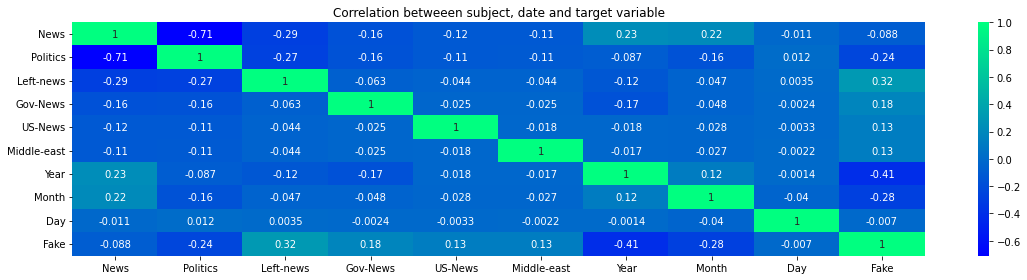

In [ ]:
# Columns related to the vectors used for the correlation
cols = ['News', 'Politics', 'Left-news', 'Gov-News', 'US-News', 'Middle-east', 'Year', 'Month', 'Day', 'Fake'] 

# Computing correlation matrix from the vector previously assembled
matrix = Correlation.corr(data_corr, 'corr_vector', method='spearman').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=cols) 

# Plotting correlation matrix
plt.figure(figsize=(16,4))  
sns.heatmap(corr_matrix_df, 
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  
            cmap="winter", 
            annot=True)
plt.title('Correlation betweeen subject, date and target variable')
plt.tight_layout()
plt.savefig('CorrMatrixSubject.png', dpi=600) 
plt.show()

In [ ]:
# Dividing the dataset to separate by true and fake
dates_fake = [data[0] for data in data_nlp.select('date').filter(col("fake") == 1).collect()]
dates_true = [data[0] for data in data_nlp.select('date').filter(col("fake") == 0).collect()]

dates_fake_plot = []
dates_true_plot = []

# Converting strings into date format to plot
for i in range(len(dates_fake)):
  temp = datetime.strptime(dates_fake[i], '%Y-%m-%d')
  dates_fake_plot.append(temp)

for i in range(len(dates_true)):
  temp = datetime.strptime(dates_true[i], '%Y-%m-%d')
  dates_true_plot.append(temp)

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


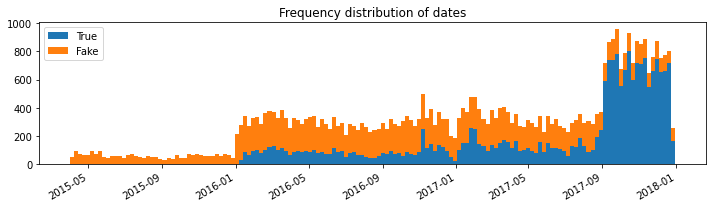

In [ ]:
# Plotting distribution of dates
fig, ax = plt.subplots(figsize=(10,3))
n, bins, patches = ax.hist([dates_true_plot, dates_fake_plot], bins=150, stacked=True, color=["tab:blue", "tab:orange"])
plt.legend({'True': "tab:blue", 'Fake': "tab:orange"})
plt.title('Frequency distribution of dates')
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig('PlotDates.png', dpi=600) 
plt.show()

In [ ]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [data[0] for data in data_nlp.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)

In [ ]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

In [ ]:
len(word_frequency[0])

114671

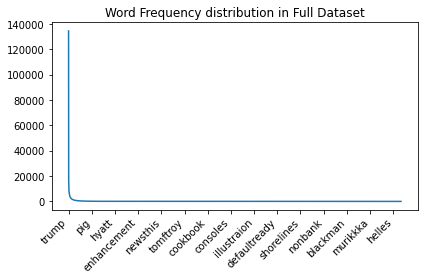

In [ ]:
# Word Frequency Full dataset
x = word_frequency[1]
y = word_frequency[0]

fig, ax = plt.subplots()
ax.plot(x, y) 
ax.set_title("Word Frequency distribution in Full Dataset")
ax.set_xticks(x[::8000])
ax.set_xticklabels(x[::8000], rotation=45, ha="right")
plt.tight_layout()
plt.savefig('WordFrequency.png', dpi=600)
plt.show()

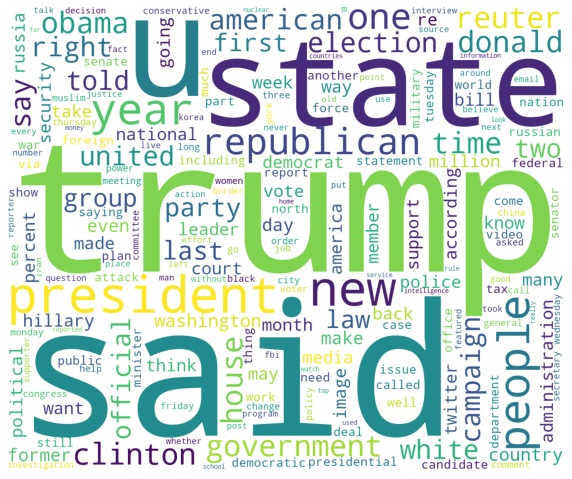

In [ ]:
plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
wordcloud.to_file("WordcloudFull.png")
plt.imshow(wordcloud)

In [ ]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

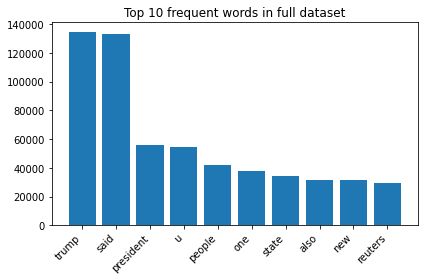

In [ ]:
# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Top 10 frequent words in full dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('10FrequentFull.png', dpi=600) 
plt.show()

In [ ]:
fake_data = data_nlp.select("textTokens").filter(col("fake") == 1)
print(fake_data.count())
fake_data.show(5)

23436
+--------------------+
|          textTokens|
+--------------------+
|[donald, trump, c...|
|[house, intellige...|
|[friday, revealed...|
|[christmas, day, ...|
|[pope, francis, u...|
+--------------------+
only showing top 5 rows



In [ ]:
fake_words = [data[0] for data in fake_data.collect()]
fake_full_words = []
for i in range(len(fake_words)):
    fake_full_words.append(" ".join(fake_words[i]))

fake_wordcloud_words = " ".join(fake_full_words)
fake_wordcloud_words[0:100]

'donald trump couldn wish americans happy new year leave instead give shout enemies haters dishonest '

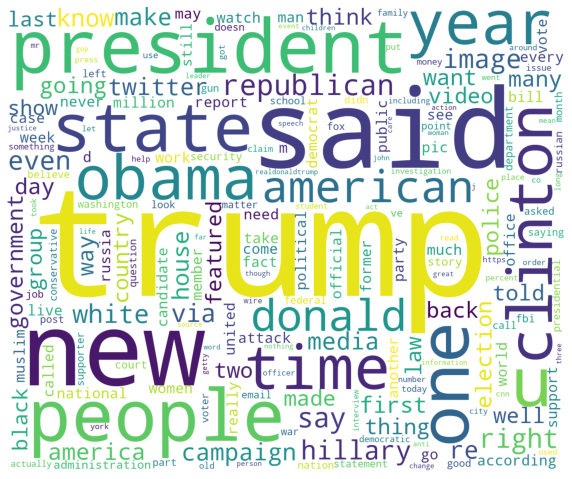

In [ ]:
plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(fake_wordcloud_words)
plt.axis('off')
wordcloud.to_file("WordcloudFake.png")
plt.imshow(wordcloud)

In [ ]:
# Putting together all lists of fake words to form a single list containing occurrences of fake words
fake_words_list = []
for i in range(len(fake_words)):
    fake_words_list += fake_words[i]

# Creating an RDD with fake words
fake_words_rdd = sc.parallelize(fake_words_list)

# Counting occurences for each word
fake_wordcount = fake_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
fake_word_frequency = list(map(list, zip(*fake_wordcount)))

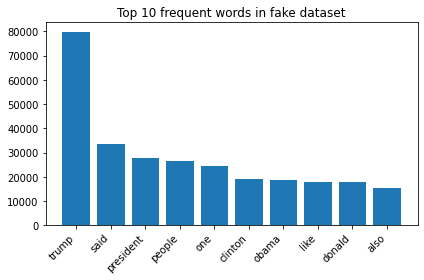

In [ ]:
# Word Frequency fake dataset
plt.bar(fake_word_frequency[1], fake_word_frequency[0]) 
plt.title("Top 10 frequent words in fake dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('10FrequentFake.png', dpi=600) 
plt.show()

In [ ]:
real_data = data_nlp.select("textTokens").filter(col("fake") == 0)
print(real_data.count())
real_data.show(5)

21417
+--------------------+
|          textTokens|
+--------------------+
|[washington, reut...|
|[washington, reut...|
|[washington, reut...|
|[washington, reut...|
|[seattle, washing...|
+--------------------+
only showing top 5 rows



In [ ]:
real_words = [data[0] for data in real_data.collect()]
real_full_words = []
for i in range(len(real_words)):
    real_full_words.append(" ".join(real_words[i]))

real_wordcloud_words = " ".join(real_full_words)
real_wordcloud_words[0:100]

'washington reuters head conservative republican faction u congress voted month huge expansion nation'

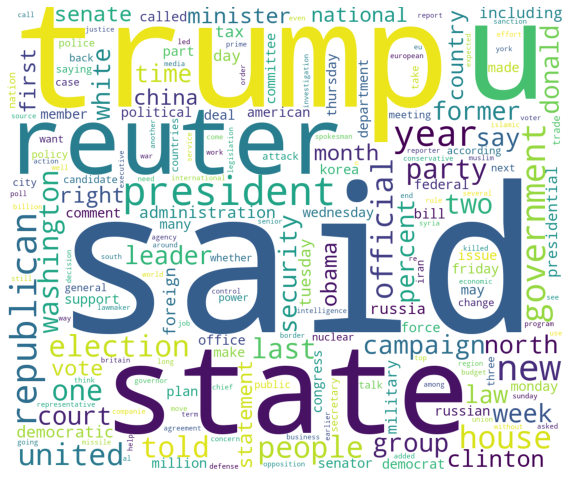

In [ ]:
plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(real_wordcloud_words)
plt.axis('off')
wordcloud.to_file("WordcloudTrue.png")
plt.imshow(wordcloud)

In [ ]:
# Putting together all lists of real words to form a single list containing occurrences of real words
real_words_list = []
for i in range(len(real_words)):
    real_words_list += real_words[i]

# Creating an RDD with real words
real_words_rdd = sc.parallelize(real_words_list)

# Counting occurences for each word
real_wordcount = real_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
real_word_frequency = list(map(list, zip(*real_wordcount)))

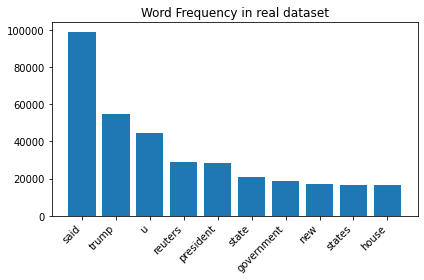

In [ ]:
# Word Frequency real dataset
plt.bar(real_word_frequency[1], real_word_frequency[0]) 
plt.title("Word Frequency in real dataset")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig('10FrequentTrue.png', dpi=600)
plt.show()

# **<font color="#34ebdb">2.0 TOPIC MODELLING</font>**

In [65]:
# Selecting the vectorized text variable with full features
data_cluster = data_nlp_vec_fullfeatures.select('id','textTokens_vecfull')
data_cluster.show(5)

+---+--------------------+
| id|  textTokens_vecfull|
+---+--------------------+
|  0|(114671,[0,2,4,5,...|
|  1|(114671,[0,1,2,8,...|
|  2|(114671,[0,4,5,12...|
|  3|(114671,[0,2,4,7,...|
|  4|(114671,[0,1,4,5,...|
+---+--------------------+
only showing top 5 rows



## **<font color="#FBBF44">2.1 K-MEANS</font>**

In [77]:
# Computing silhouette score the get optimal number of clusters with elbow method
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='textTokens_vecfull', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):
  KMeans_=KMeans(featuresCol='textTokens_vecfull', k=K)
  KMeans_fit=KMeans_.fit(data_cluster)
  KMeans_transform=KMeans_fit.transform(data_cluster) 
  evaluation_score=evaluator.evaluate(KMeans_transform)
  silhouette_scores.append(evaluation_score)

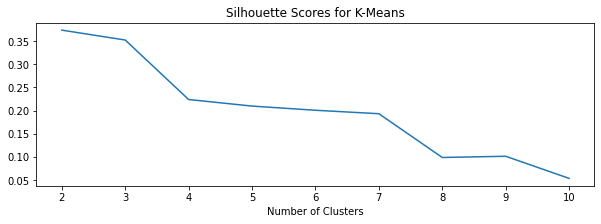

In [78]:
plt.figure(figsize=(10, 3))
plt.plot(range(2,11), silhouette_scores)
plt.title('Silhouette Scores for K-Means')
plt.xlabel('Number of Clusters')
plt.savefig('K-Means_silhouette.png', dpi=600)

In [98]:
kmeans = KMeans(featuresCol='textTokens_vecfull').setK(4).setSeed(1)
modelk = kmeans.fit(data_cluster)

# Make predictions
predictions = modelk.transform(data_cluster)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='textTokens_vecfull')

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = modelk.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.2083229366850883
Cluster Centers: 
[0.98766467 1.68581772 0.79220997 ... 0.00003352 0.00003352 0.00003352]
[11.56571506  3.2193644   2.2806356  ...  0.          0.
  0.        ]
[2.30701278 7.76936668 1.86028812 ... 0.         0.         0.        ]
[8.90677966 5.99152542 7.11440678 ... 0.         0.         0.        ]


In [99]:
# Viewing the label assigned to each record belonging to which cluster
data_cluster_label = modelk.transform(data_cluster)
data_cluster_label.show(5)

+---+--------------------+----------+
| id|  textTokens_vecfull|prediction|
+---+--------------------+----------+
|  0|(114671,[0,2,4,5,...|         1|
|  1|(114671,[0,1,2,8,...|         0|
|  2|(114671,[0,4,5,12...|         0|
|  3|(114671,[0,2,4,7,...|         1|
|  4|(114671,[0,1,4,5,...|         0|
+---+--------------------+----------+
only showing top 5 rows



In [100]:
data_cluster_label = data_cluster_label.join(data_nlp, 'id')
data_cluster_label = data_cluster_label.select('id', 'textTokens', 'prediction')
data_cluster_label.show(5)

+----+--------------------+----------+
|  id|          textTokens|prediction|
+----+--------------------+----------+
|  26|[ronald, reagan, ...|         0|
|  29|[sen, al, franken...|         1|
| 474|[u, sen, ted, cru...|         0|
| 964|[say, people, are...|         0|
|1677|[seem, democrats,...|         0|
+----+--------------------+----------+
only showing top 5 rows



In [102]:
# Separating clusters and counting them
dk0 = data_cluster_label.filter(data_cluster_label.prediction == 0)
dk1 = data_cluster_label.filter(data_cluster_label.prediction == 1)
dk2 = data_cluster_label.filter(data_cluster_label.prediction == 2)
dk3 = data_cluster_label.filter(data_cluster_label.prediction == 3)

print('Amount of records in cluster 0:', dk0.count())
print('Amount of records in cluster 1:', dk1.count())
print('Amount of records in cluster 2:', dk2.count())
print('Amount of records in cluster 3:', dk3.count())

Amount of records in cluster 0: 29764
Amount of records in cluster 1: 7416
Amount of records in cluster 2: 7437
Amount of records in cluster 3: 236


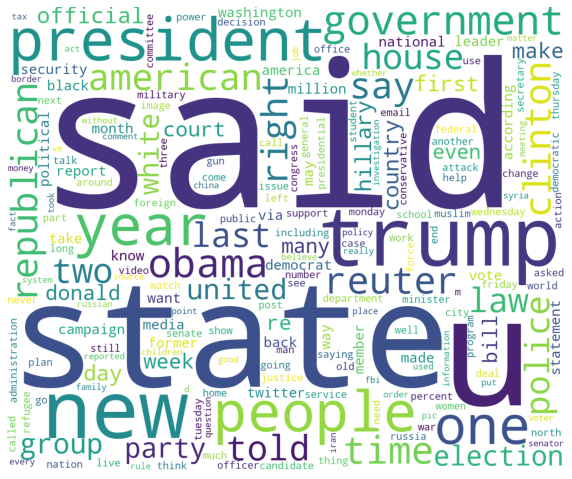

In [ ]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [cl_data[0] for cl_data in dk0.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)


# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))


plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
plt.imshow(wordcloud)

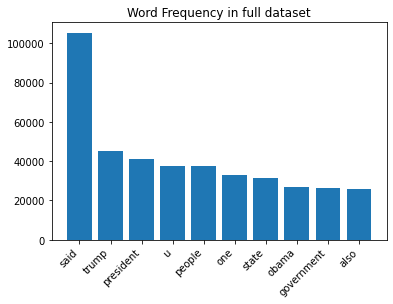

In [ ]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Word Frequency in full dataset")
plt.xticks(rotation=45, ha="right")
plt.show()

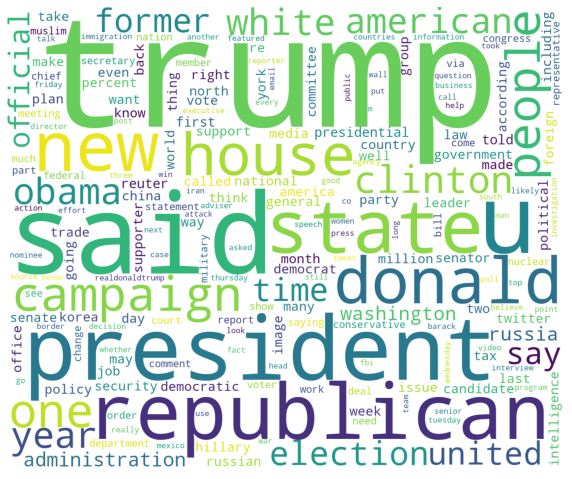

In [ ]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [cl_data[0] for cl_data in dk1.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)


# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))


plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
plt.imshow(wordcloud)

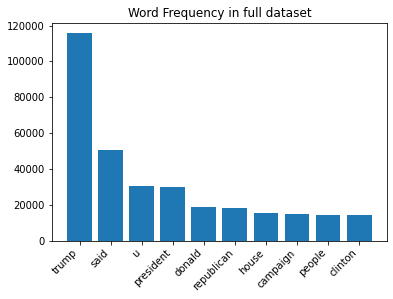

In [ ]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Word Frequency in full dataset")
plt.xticks(rotation=45, ha="right")
plt.show()

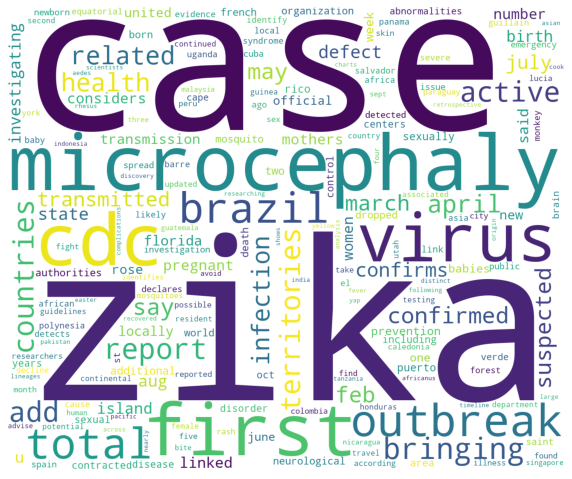

In [ ]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [cl_data[0] for cl_data in dk2.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)


# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))


plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
plt.imshow(wordcloud)

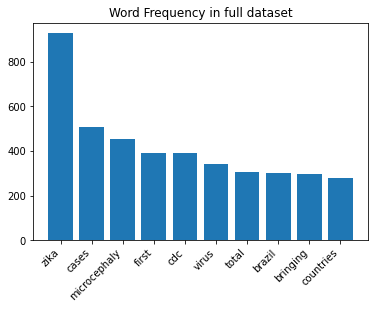

In [ ]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Word Frequency in full dataset")
plt.xticks(rotation=45, ha="right")
plt.show()

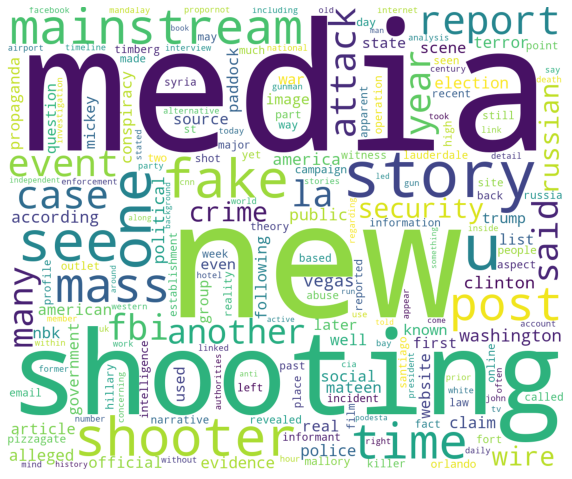

In [ ]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [cl_data[0] for cl_data in dk3.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)


# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))


plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
plt.imshow(wordcloud)

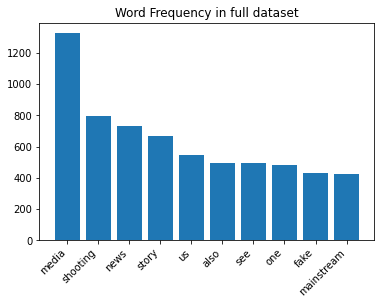

In [ ]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Word Frequency in full dataset")
plt.xticks(rotation=45, ha="right")
plt.show()

## **<font color="#FBBF44">2.2 BISECTING K-MEANS</font>**

In [79]:
silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='textTokens_vecfull', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):
  BKMeans_= BisectingKMeans(featuresCol='textTokens_vecfull', k=K)
  BKMeans_fit=BKMeans_.fit(data_cluster)
  BKMeans_transform=BKMeans_fit.transform(data_cluster) 
  evaluation_score=evaluator.evaluate(BKMeans_transform)
  silhouette_scores.append(evaluation_score)

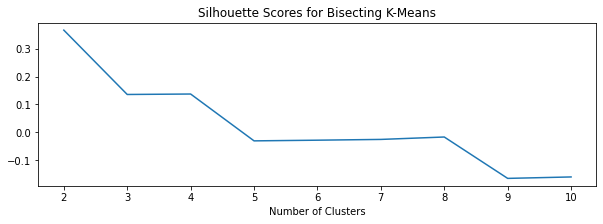

In [81]:
plt.figure(figsize=(10, 3))
plt.plot(range(2,11), silhouette_scores)
plt.title('Silhouette Scores for Bisecting K-Means')
plt.xlabel('Number of Clusters')
plt.savefig('BK-Means_silhouette.png', dpi=600)

In [83]:
bkm = BisectingKMeans(featuresCol='textTokens_vecfull').setK(5).setSeed(1)
modelbk = bkm.fit(data_cluster)

# Make predictions
predictions = modelbk.transform(data_cluster)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(featuresCol='textTokens_vecfull')

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
print("Cluster Centers: ")
centers = modelbk.clusterCenters()
for center in centers:
    print(center)

Silhouette with squared euclidean distance = -0.031550932092296785
Cluster Centers: 
[0.47538434 1.27929652 0.50583239 ... 0.         0.         0.        ]
[2.71748118 1.137284   1.27106965 ... 0.         0.         0.00010601]
[0.62811555 5.75899468 1.165815   ... 0.00010429 0.00010429 0.        ]
[11.03714383  2.56987788  2.15535957 ...  0.          0.
  0.        ]
[9.24487259 9.41330019 3.60596644 ... 0.         0.         0.        ]


In [84]:
# Viewing the label assigned to each record belonging to which cluster
data_cluster_label = modelbk.transform(data_cluster)
data_cluster_label.show(5)

+---+--------------------+----------+
| id|  textTokens_vecfull|prediction|
+---+--------------------+----------+
|  0|(114671,[0,2,4,5,...|         3|
|  1|(114671,[0,1,2,8,...|         1|
|  2|(114671,[0,4,5,12...|         1|
|  3|(114671,[0,2,4,7,...|         3|
|  4|(114671,[0,1,4,5,...|         1|
+---+--------------------+----------+
only showing top 5 rows



In [85]:
data_cluster_label = data_cluster_label.join(data_nlp, 'id')
data_cluster_label = data_cluster_label.select('id', 'textTokens', 'prediction')
data_cluster_label.show(5)

+----+--------------------+----------+
|  id|          textTokens|prediction|
+----+--------------------+----------+
|  26|[ronald, reagan, ...|         1|
|  29|[sen, al, franken...|         1|
| 474|[u, sen, ted, cru...|         2|
| 964|[say, people, are...|         1|
|1677|[seem, democrats,...|         1|
+----+--------------------+----------+
only showing top 5 rows



In [87]:
# Separating clusters and counting them
dk0 = data_cluster_label.filter(data_cluster_label.prediction == 0)
dk1 = data_cluster_label.filter(data_cluster_label.prediction == 1)
dk2 = data_cluster_label.filter(data_cluster_label.prediction == 2)
dk3 = data_cluster_label.filter(data_cluster_label.prediction == 3)
dk4 = data_cluster_label.filter(data_cluster_label.prediction == 4)

print('Amount of records in cluster 0:', dk0.count())
print('Amount of records in cluster 1:', dk1.count())
print('Amount of records in cluster 2:', dk2.count())
print('Amount of records in cluster 3:', dk3.count())
print('Amount of records in cluster 4:', dk4.count())

Amount of records in cluster 0: 16719
Amount of records in cluster 1: 9431
Amount of records in cluster 2: 9589
Amount of records in cluster 3: 5896
Amount of records in cluster 4: 3218


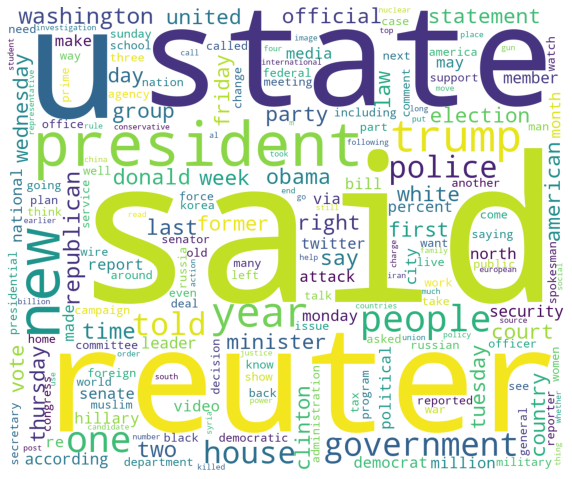

In [88]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [cl_data[0] for cl_data in dk0.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)


# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))


plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
plt.imshow(wordcloud)

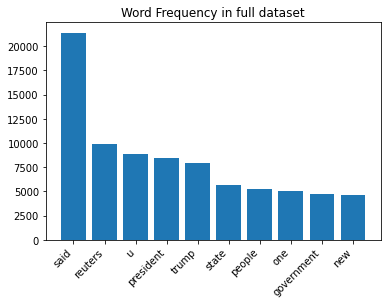

In [89]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Word Frequency in full dataset")
plt.xticks(rotation=45, ha="right")
plt.show()

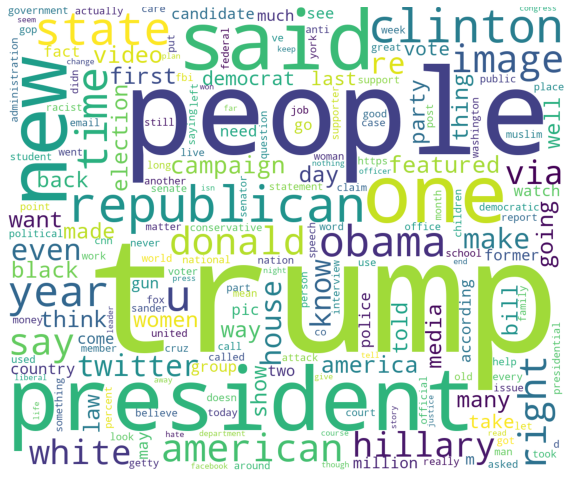

In [90]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [cl_data[0] for cl_data in dk1.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)


# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))


plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
plt.imshow(wordcloud)

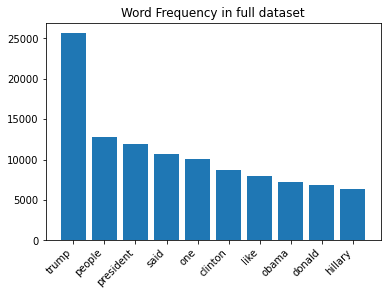

In [91]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Word Frequency in full dataset")
plt.xticks(rotation=45, ha="right")
plt.show()

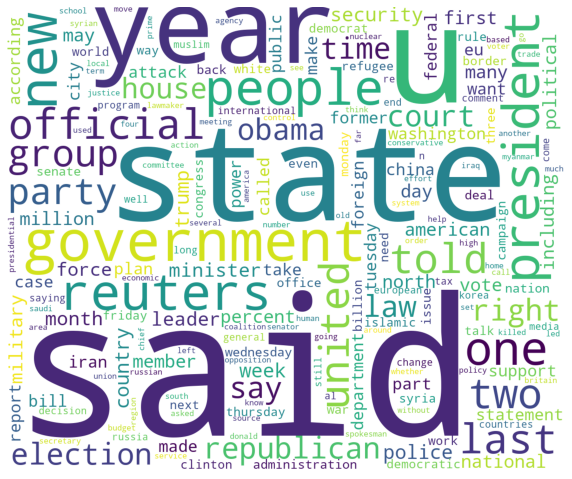

In [92]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [cl_data[0] for cl_data in dk2.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)


# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))


plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
plt.imshow(wordcloud)

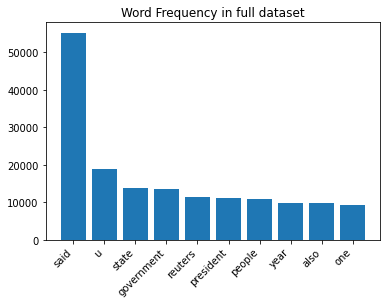

In [93]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Word Frequency in full dataset")
plt.xticks(rotation=45, ha="right")
plt.show()

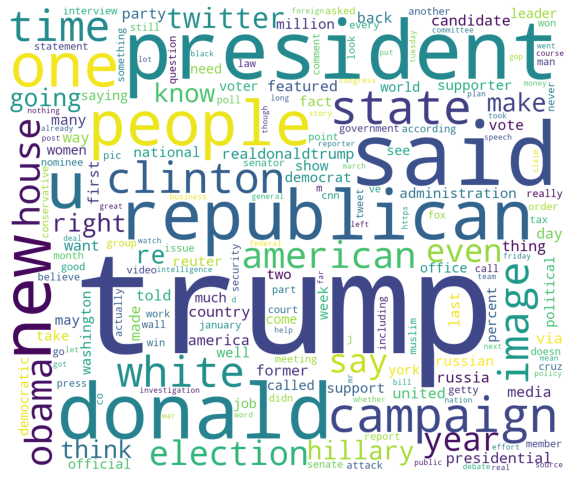

In [94]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [cl_data[0] for cl_data in dk3.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)


# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))


plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
plt.imshow(wordcloud)

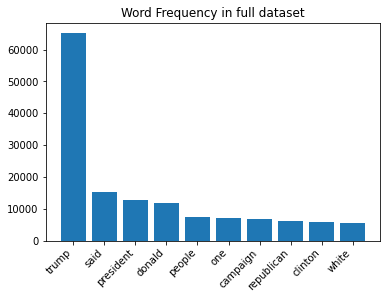

In [95]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Word Frequency in full dataset")
plt.xticks(rotation=45, ha="right")
plt.show()

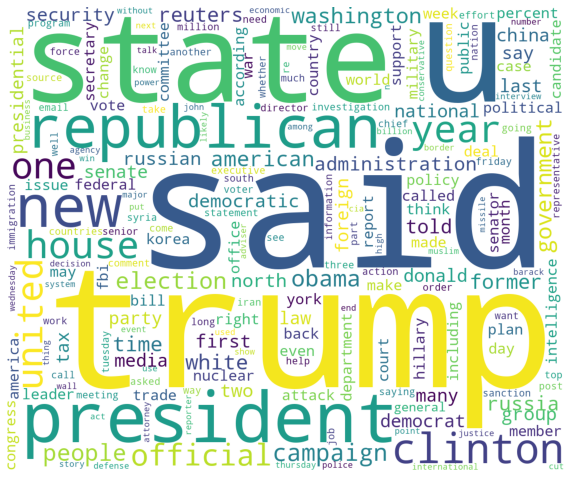

In [96]:
# Collecting all tokens from the previous dataset in order to put them into a single string 
# and visualize a wordcloud with the most prominent words
words = [cl_data[0] for cl_data in dk4.select('textTokens').collect()]
full_words = []
for i in range(len(words)):
    full_words.append(" ".join(words[i]))

wordcloud_words = " ".join(full_words)


# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .collect()

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))


plt.figure(figsize=(10,10))
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(wordcloud_words)
plt.axis('off')
plt.imshow(wordcloud)

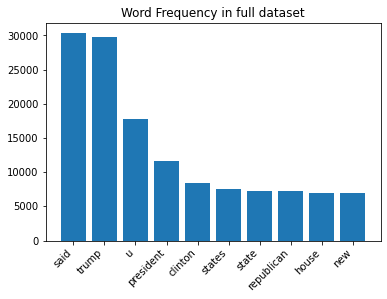

In [97]:
# Putting together all lists of fake words to form a single list containing occurrences of words
full_words_list = []
for i in range(len(words)):
    full_words_list += words[i]

# Creating an RDD with words
full_words_rdd = sc.parallelize(full_words_list)

# Counting occurences for each word
wordcount = full_words_rdd.flatMap(lambda x: x.split(' ')) \
                          .map(lambda x: (x,1)) \
                          .reduceByKey(lambda x,y:x+y) \
                          .map(lambda x: (x[1], x[0])) \
                          .sortByKey(False) \
                          .take(10)

# Turning list of tuples previously obtained into two separate lists
word_frequency = list(map(list, zip(*wordcount)))

# Word Frequency Full dataset
plt.bar(word_frequency[1], word_frequency[0]) 
plt.title("Word Frequency in full dataset")
plt.xticks(rotation=45, ha="right")
plt.show()

## **<font color="#FBBF44">2.3 LATENT DIRICHLET ALLOCATION</font>**




In [77]:
# Selecting the vectorized text variable
data_cluster = data_nlp_vec.select('id','textTokens_vec')
data_cluster.show(5)

+---+--------------------+
| id|      textTokens_vec|
+---+--------------------+
|  0|(3024,[0,2,4,5,7,...|
|  1|(3024,[0,1,2,8,10...|
|  2|(3024,[0,4,5,12,1...|
|  3|(3024,[0,2,4,7,11...|
|  4|(3024,[0,1,4,5,12...|
+---+--------------------+
only showing top 5 rows



In [104]:
perplexity=[]

for K in tqdm(range(2,6)):
    lda_=LDA(k=K, maxIter=10, featuresCol = 'textTokens_vec')
    lda_fit=lda_.fit(data_cluster) 
    evaluation_score=lda_fit.logPerplexity(data_cluster)
    perplexity.append(str(evaluation_score))

100%|██████████| 4/4 [1:03:22<00:00, 950.71s/it] 


In [105]:
perplexity

['8.638651618782573',
 '8.608240995789902',
 '8.658778034781829',
 '8.67310653133198']

Text(0, 0.5, 'Perplexity')

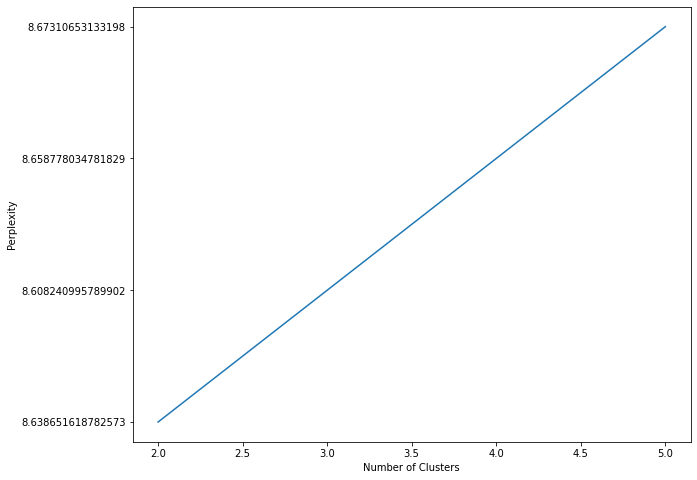

In [107]:
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,6),perplexity)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Perplexity')

In [79]:
lda = LDA(k=30, maxIter=100, featuresCol = 'textTokens_vec')
modellda = lda.fit(data_cluster)

ll = modellda.logLikelihood(data_cluster)
lp = modellda.logPerplexity(data_cluster)

In [80]:
print("The lower bound on the log likelihood of the entire corpus: " + str(ll))
print("The upper bound on perplexity: " + str(lp))

# Describe topics.
vocab = cv_model.vocabulary
topicslda = modellda.describeTopics()
t = modellda.describeTopics().collect()
topic_inds = [ind.termIndices for ind in t]

topicsl = []
for topic in topic_inds:
  _topic = []
  for ind in topic:
    _topic.append(vocab[ind]) 
  topicsl.append(_topic)

# Shows the result
transformedlda = modellda.transform(data_cluster).select('id','topicDistribution')
transformedlda.show(5)

The lower bound on the log likelihood of the entire corpus: -55539719.189070895
The upper bound on perplexity: 7.059980031249009
+---+--------------------+
| id|   topicDistribution|
+---+--------------------+
|  0|[1.46681296457461...|
|  1|[2.11550528661767...|
|  2|[1.32675586786966...|
|  3|[1.48170958991239...|
|  4|[1.95925599661544...|
+---+--------------------+
only showing top 5 rows



In [81]:
for i, topic in enumerate(topicsl, start=1):
  print(f"topic {i}: {topic}")

topic 1: ['said', 'eu', 'britain', 'minister', 'may', 'european', 'prime', 'british', 'london', 'brexit']
topic 2: ['senate', 'bill', 'said', 'republicans', 'house', 'republican', 'health', 'legislation', 'obamacare', 'democrats']
topic 3: ['trump', 'said', 'u', 'president', 'house', 'russia', 'russian', 'white', 'former', 'washington']
topic 4: ['sanders', 'campaign', 'cruz', 'clinton', 'presidential', 'bernie', 'said', 'democratic', 'senator', 'candidate']
topic 5: ['fbi', 'information', 'investigation', 'said', 'department', 'emails', 'email', 'documents', 'clinton', 'evidence']
topic 6: ['u', 'said', 'united', 'israel', 'states', 'trump', 'president', 'mexico', 'jerusalem', 'countries']
topic 7: ['court', 'said', 'u', 'law', 'trump', 'order', 'judge', 'federal', 'states', 'supreme']
topic 8: ['said', 'reuters', 'state', 'government', 'u', 'military', 'syria', 'al', 'islamic', 'saudi']
topic 9: ['workers', 'first', 'work', 'jobs', 'food', 'president', 'labor', 'wage', 'pay', 'housin

# **<font color="#34ebdb">3.0 CLASSIFICATION</font>**

In [ ]:
def getAP(y_test, y_proba):
  AP = average_precision_score(y_test, y_proba, average='weighted')
  return np.round(AP, 4)

def getAUC(y_test, y_proba):
  AUC = roc_auc_score(y_test, y_proba, average='weighted')
  return np.round(AUC, 4)

In [ ]:
# Putting together a vector for classification
assembler = VectorAssembler(inputCols=['titleTokens_vec',
                                       'subject_vec',
                                       'date_vec'], 
                            outputCol="clf_vector")
data_clf = assembler.transform(data_nlp_vec)
data_clf.show(5)

+--------------------+--------------------+-------------+------------------+--------------------+----+--------------------+
|     titleTokens_vec|      textTokens_vec|  subject_vec|          date_vec|       full_features|fake|          clf_vector|
+--------------------+--------------------+-------------+------------------+--------------------+----+--------------------+
|(88,[0,9,24],[1.0...|(3024,[0,2,4,5,7,...|(6,[0],[1.0])|[2017.0,12.0,31.0]|(3121,[0,9,24,88,...|   1|(97,[0,9,24,88,94...|
|(88,[0,43],[1.0,1...|(3024,[0,1,2,8,10...|(6,[0],[1.0])|[2017.0,12.0,31.0]|(3121,[0,43,88,89...|   1|(97,[0,43,88,94,9...|
|     (88,[51],[1.0])|(3024,[0,4,5,12,1...|(6,[0],[1.0])|[2017.0,12.0,30.0]|(3121,[51,88,92,9...|   1|(97,[51,88,94,95,...|
|(88,[0,4],[1.0,1.0])|(3024,[0,2,4,7,11...|(6,[0],[1.0])|[2017.0,12.0,29.0]|(3121,[0,4,88,90,...|   1|(97,[0,4,88,94,95...|
|(88,[0,24,64],[1....|(3024,[0,1,4,5,12...|(6,[0],[1.0])|[2017.0,12.0,25.0]|(3121,[0,24,64,88...|   1|(97,[0,24,64,88,9...|
+-------

In [ ]:
# Splitting training and testing data
(data_train, data_test) = data_clf.select('clf_vector','fake').randomSplit([0.7, 0.3], seed = 42)
print('Number of training records: ', data_train.count())
print('Number of testing records: ', data_test.count())
data_test.show(5)

Number of training records:  31567
Number of testing records:  13286
+--------------------+----+
|          clf_vector|fake|
+--------------------+----+
|(97,[0,1,2,4,12,4...|   1|
|(97,[0,1,2,11,36,...|   1|
|(97,[0,1,2,14,38,...|   1|
|(97,[0,1,2,14,38,...|   1|
|(97,[0,1,2,29,88,...|   1|
+--------------------+----+
only showing top 5 rows



## **<font color="#FBBF44">3.1 DECISION TREE</font>**

In [ ]:
# Creating classifier with default parameters
dec_tree = DecisionTreeClassifier(featuresCol='clf_vector',labelCol='fake').fit(data_train)
predictions = dec_tree.transform(data_test)
predictions.show(5)

+--------------------+----+-------------+--------------------+----------+
|          clf_vector|fake|rawPrediction|         probability|prediction|
+--------------------+----+-------------+--------------------+----------+
|(97,[0,1,2,4,12,4...|   1|   [1.0,86.0]|[0.01149425287356...|       1.0|
|(97,[0,1,2,11,36,...|   1|   [1.0,86.0]|[0.01149425287356...|       1.0|
|(97,[0,1,2,14,38,...|   1|    [1.0,1.0]|           [0.5,0.5]|       0.0|
|(97,[0,1,2,14,38,...|   1|    [1.0,1.0]|           [0.5,0.5]|       0.0|
|(97,[0,1,2,29,88,...|   1|   [1.0,86.0]|[0.01149425287356...|       1.0|
+--------------------+----+-------------+--------------------+----------+
only showing top 5 rows



In [ ]:
# Getting predictions and correct label to later pass as rdd to get classifier metrics
preds_and_labels = predictions.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                           .withColumn("fake",col("fake").cast('float'))

bin_metrics = BinaryClassificationMetrics(preds_and_labels.rdd.map(tuple))
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# Again collecting predictions and true label, this time as lists, to use for example in confusion matrix
# Also collecting probabilities to be used in ROC curve
y_pred = predictions.select('prediction').rdd.keys().collect()
y_proba = predictions.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_test = predictions.select("fake").rdd.keys().collect()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Metrics report
print('Accuracy:', np.round(metrics.accuracy ,4))
print('AUC:', np.round(bin_metrics.areaUnderROC ,4))
print('AP:', np.round(bin_metrics.areaUnderPR ,4), '\n')

print('Precision for class 0:', np.round(metrics.precision(0.0) ,4))
print('Precision for class 1:', np.round(metrics.precision(1.0) ,4))
print('Weighted Precision:', np.round(metrics.weightedPrecision ,4), '\n')

print('Recall for class 0:', np.round(metrics.recall(0.0) ,4))
print('Recall for class 1:', np.round(metrics.recall(1.0) ,4))
print('Weighted Recall:', np.round(metrics.weightedRecall ,4), '\n')

print('F-score for class 0:', np.round(metrics.fMeasure(0.0) ,4))
print('F-score for class 1:', np.round(metrics.fMeasure(1.0) ,4))
print('Weighted F-score:', np.round(metrics.weightedFMeasure(), 4))

Accuracy: 0.9238
AUC: 0.9268
AP: 0.9553 

Precision for class 0: 0.8704
Precision for class 1: 0.9858
Weighted Precision: 0.931 

Recall for class 0: 0.9862
Recall for class 1: 0.8674
Weighted Recall: 0.9238 

F-score for class 0: 0.9247
F-score for class 1: 0.9228
Weighted F-score: 0.9237


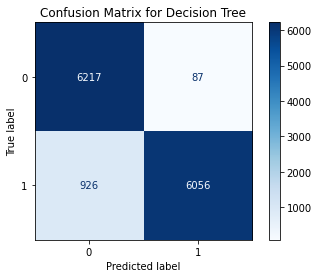

In [ ]:
# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title('Confusion Matrix for Decision Tree')
plt.savefig('CM-DT.png', dpi=600) 
plt.show()

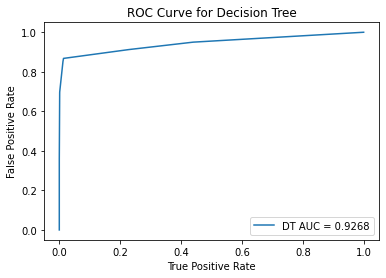

In [ ]:
# Getting false and true positive rate to plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label='DT AUC = '+str(np.round(bin_metrics.areaUnderROC,4)))
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree')  
plt.legend(loc='lower right')
# plt.savefig('CM.png', dpi=600) 
plt.show()

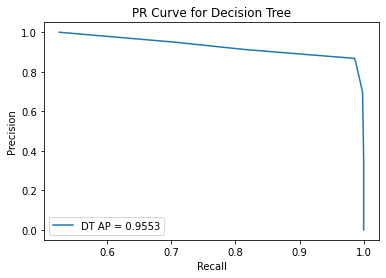

In [ ]:
# Getting precision and recall to plot PR curve
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(prec, rec, label='DT AP = ' + str(np.round(bin_metrics.areaUnderPR,4)))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve for Decision Tree') 
plt.legend(loc='lower left')
# plt.savefig('CM.png', dpi=600) 
plt.show()

## **<font color="#FBBF44">3.2 LOGISTIC REGRESSION</font>**

In [ ]:
log_reg = LogisticRegression(featuresCol='clf_vector', labelCol='fake').fit(data_train)
predictions = log_reg.transform(data_test)
predictions.show(5)

+--------------------+----+--------------------+--------------------+----------+
|          clf_vector|fake|       rawPrediction|         probability|prediction|
+--------------------+----+--------------------+--------------------+----------+
|(97,[0,1,2,4,12,4...|   1|[-5.0605105447457...|[0.00630234912869...|       1.0|
|(97,[0,1,2,11,36,...|   1|[-2.2448719804033...|[0.09579271612831...|       1.0|
|(97,[0,1,2,14,38,...|   1|[-9.0465543177697...|[1.17782352489219...|       1.0|
|(97,[0,1,2,14,38,...|   1|[-28.515702804197...|[4.12845565952549...|       1.0|
|(97,[0,1,2,29,88,...|   1|[-7.9252034714982...|[3.61385637293547...|       1.0|
+--------------------+----+--------------------+--------------------+----------+
only showing top 5 rows



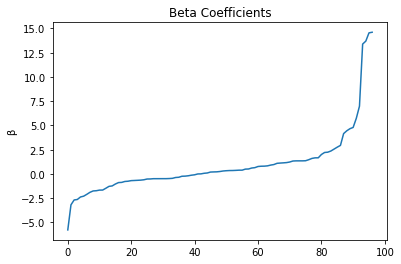

In [ ]:
beta = np.sort(log_reg.coefficients)
plt.plot(beta)
plt.title('Beta Coefficients')
plt.ylabel('β')
plt.show()

In [ ]:
# Getting predictions and correct label to later pass as rdd to get classifier metrics
preds_and_labels = predictions.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                           .withColumn("fake",col("fake").cast('float'))

bin_metrics = BinaryClassificationMetrics(preds_and_labels.rdd.map(tuple))
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# Again collecting predictions and true label, this time as lists, to use for example in confusion matrix
# Also collecting probabilities to be used in ROC curve
y_pred = predictions.select('prediction').rdd.keys().collect()
y_proba = predictions.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_test = predictions.select("fake").rdd.keys().collect()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Metrics report
print('Accuracy:', np.round(metrics.accuracy ,4))
print('AUC:', np.round(bin_metrics.areaUnderROC ,4))
print('AP:', np.round(bin_metrics.areaUnderPR ,4), '\n')

print('Precision for class 0:', np.round(metrics.precision(0.0) ,4))
print('Precision for class 1:', np.round(metrics.precision(1.0) ,4))
print('Weighted Precision:', np.round(metrics.weightedPrecision ,4), '\n')

print('Recall for class 0:', np.round(metrics.recall(0.0) ,4))
print('Recall for class 1:', np.round(metrics.recall(1.0) ,4))
print('Weighted Recall:', np.round(metrics.weightedRecall ,4), '\n')

print('F-score for class 0:', np.round(metrics.fMeasure(0.0) ,4))
print('F-score for class 1:', np.round(metrics.fMeasure(1.0) ,4))
print('Weighted F-score:', np.round(metrics.weightedFMeasure(), 4))

Accuracy: 0.9275
AUC: 0.9287
AP: 0.9345 

Precision for class 0: 0.9003
Precision for class 1: 0.955
Weighted Precision: 0.929 

Recall for class 0: 0.9527
Recall for class 1: 0.9048
Weighted Recall: 0.9275 

F-score for class 0: 0.9258
F-score for class 1: 0.9292
Weighted F-score: 0.9276


In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="fake")
evaluator.evaluate(predictions)

0.9706750575628119

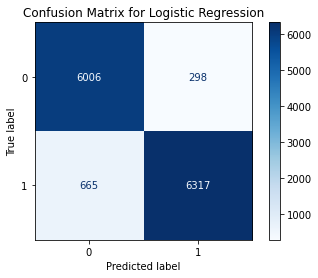

In [ ]:
# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title('Confusion Matrix for Logistic Regression')
plt.savefig('CM-LR.png', dpi=600) 
plt.show()

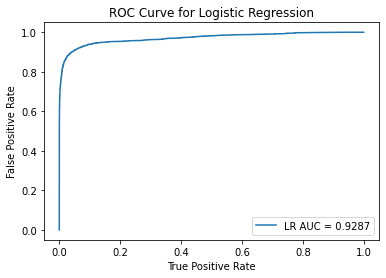

In [ ]:
# Getting false and true positive rate to plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label='LR AUC = '+str(np.round(bin_metrics.areaUnderROC,4)))
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')  
plt.legend(loc='lower right')
# plt.savefig('CM.png', dpi=600) 
plt.show()

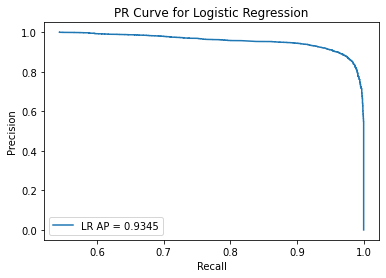

In [ ]:
# Getting precision and recall to plot PR curve
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(prec, rec, label='LR AP = ' + str(np.round(bin_metrics.areaUnderPR,4)))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve for Logistic Regression') 
plt.legend(loc='lower left')
# plt.savefig('CM.png', dpi=600) 
plt.show()

## **<font color="#FBBF44">3.3 SUPPORT VECTOR MACHINE</font>**

In [ ]:
svc = LinearSVC(featuresCol='clf_vector', labelCol='fake').fit(data_train)
predictions = svc.transform(data_test)
predictions.show(5)

+--------------------+----+--------------------+----------+
|          clf_vector|fake|       rawPrediction|prediction|
+--------------------+----+--------------------+----------+
|(97,[0,1,2,4,12,4...|   1|[-3.4991893156379...|       1.0|
|(97,[0,1,2,11,36,...|   1|[-1.4571711288731...|       1.0|
|(97,[0,1,2,14,38,...|   1|[-6.4068265033188...|       1.0|
|(97,[0,1,2,14,38,...|   1|[-11.385839797132...|       1.0|
|(97,[0,1,2,29,88,...|   1|[-5.5722883965936...|       1.0|
+--------------------+----+--------------------+----------+
only showing top 5 rows



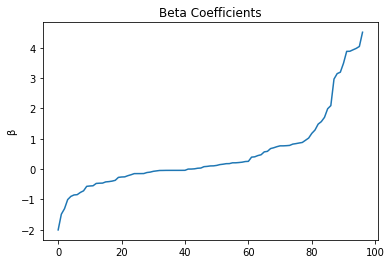

In [ ]:
beta = np.sort(svc.coefficients)
plt.plot(beta)
plt.title('Beta Coefficients')
plt.ylabel('β')
plt.show()

In [ ]:
# Getting predictions and correct label to later pass as rdd to get classifier metrics
preds_and_labels = predictions.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                           .withColumn("fake",col("fake").cast('float'))

bin_metrics = BinaryClassificationMetrics(preds_and_labels.rdd.map(tuple))
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# Again collecting predictions and true label, this time as lists, to use for example in confusion matrix
# Also collecting probabilities to be used in ROC curve
y_pred = predictions.select('prediction').rdd.keys().collect()
y_proba = predictions.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
y_test = predictions.select("fake").rdd.keys().collect()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Metrics report
print('Accuracy:', np.round(metrics.accuracy ,4))
print('AUC:', np.round(bin_metrics.areaUnderROC ,4))
print('AP:', np.round(bin_metrics.areaUnderPR ,4), '\n')

print('Precision for class 0:', np.round(metrics.precision(0.0) ,4))
print('Precision for class 1:', np.round(metrics.precision(1.0) ,4))
print('Weighted Precision:', np.round(metrics.weightedPrecision ,4), '\n')

print('Recall for class 0:', np.round(metrics.recall(0.0) ,4))
print('Recall for class 1:', np.round(metrics.recall(1.0) ,4))
print('Weighted Recall:', np.round(metrics.weightedRecall ,4), '\n')

print('F-score for class 0:', np.round(metrics.fMeasure(0.0) ,4))
print('F-score for class 1:', np.round(metrics.fMeasure(1.0) ,4))
print('Weighted F-score:', np.round(metrics.weightedFMeasure(), 4))

Accuracy: 0.9341
AUC: 0.9356
AP: 0.9466 

Precision for class 0: 0.9016
Precision for class 1: 0.9677
Weighted Precision: 0.9363 

Recall for class 0: 0.9665
Recall for class 1: 0.9048
Weighted Recall: 0.9341 

F-score for class 0: 0.9329
F-score for class 1: 0.9352
Weighted F-score: 0.9341


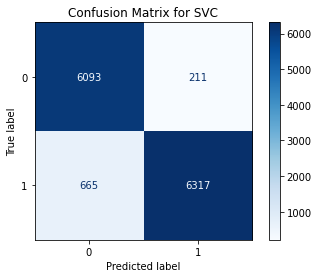

In [ ]:
# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title('Confusion Matrix for SVC')
# plt.savefig('CM.png', dpi=600) 
plt.show()

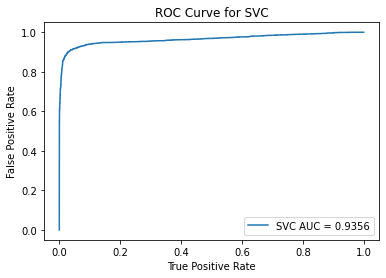

In [ ]:
# Getting false and true positive rate to plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label='SVC AUC = '+str(np.round(bin_metrics.areaUnderROC,4)))
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for SVC')  
plt.legend(loc='lower right')
# plt.savefig('CM.png', dpi=600) 
plt.show()

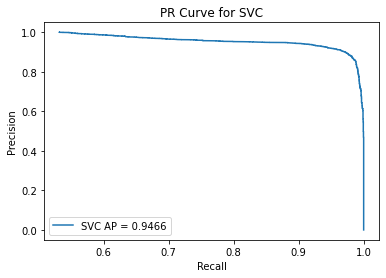

In [ ]:
# Getting precision and recall to plot PR curve
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(prec, rec, label='SVC AP = ' + str(np.round(bin_metrics.areaUnderPR,4)))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve for SVC') 
plt.legend(loc='lower left')
# plt.savefig('CM.png', dpi=600) 
plt.show()

## **<font color="#FBBF44">3.4 RANDOM FOREST</font>**

In [ ]:
# Creating classifier with default parameters
rand_forest = RandomForestClassifier(featuresCol='clf_vector',labelCol='fake').fit(data_train)
predictions = rand_forest.transform(data_test)
predictions.show(5)

+--------------------+----+--------------------+--------------------+----------+
|          clf_vector|fake|       rawPrediction|         probability|prediction|
+--------------------+----+--------------------+--------------------+----------+
|(97,[0,1,2,4,12,4...|   1|[9.29800237752921...|[0.46490011887646...|       1.0|
|(97,[0,1,2,11,36,...|   1|[9.30202615956936...|[0.46510130797846...|       1.0|
|(97,[0,1,2,14,38,...|   1|[4.26613876994833...|[0.21330693849741...|       1.0|
|(97,[0,1,2,14,38,...|   1|[1.39561586888289...|[0.06978079344414...|       1.0|
|(97,[0,1,2,29,88,...|   1|[4.95849658212931...|[0.24792482910646...|       1.0|
+--------------------+----+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
# Getting predictions and correct label to later pass as rdd to get classifier metrics
preds_and_labels = predictions.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                           .withColumn("fake",col("fake").cast('float'))

bin_metrics = BinaryClassificationMetrics(preds_and_labels.rdd.map(tuple))
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

# Again collecting predictions and true label, this time as lists, to use for example in confusion matrix
# Also collecting probabilities to be used in ROC curve
y_pred = predictions.select('prediction').rdd.keys().collect()
y_proba = predictions.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_test = predictions.select("fake").rdd.keys().collect()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [ ]:
# Metrics report
print('Accuracy:', np.round(metrics.accuracy ,4))
print('AUC:', np.round(bin_metrics.areaUnderROC ,4))
print('AP:', np.round(bin_metrics.areaUnderPR ,4), '\n')

print('Precision for class 0:', np.round(metrics.precision(0.0) ,4))
print('Precision for class 1:', np.round(metrics.precision(1.0) ,4))
print('Weighted Precision:', np.round(metrics.weightedPrecision ,4), '\n')

print('Recall for class 0:', np.round(metrics.recall(0.0) ,4))
print('Recall for class 1:', np.round(metrics.recall(1.0) ,4))
print('Weighted Recall:', np.round(metrics.weightedRecall ,4), '\n')

print('F-score for class 0:', np.round(metrics.fMeasure(0.0) ,4))
print('F-score for class 1:', np.round(metrics.fMeasure(1.0) ,4))
print('Weighted F-score:', np.round(metrics.weightedFMeasure(), 4))

Accuracy: 0.9312
AUC: 0.9338
AP: 0.958 

Precision for class 0: 0.8834
Precision for class 1: 0.985
Weighted Precision: 0.9368 

Recall for class 0: 0.9851
Recall for class 1: 0.8826
Weighted Recall: 0.9312 

F-score for class 0: 0.9315
F-score for class 1: 0.931
Weighted F-score: 0.9312


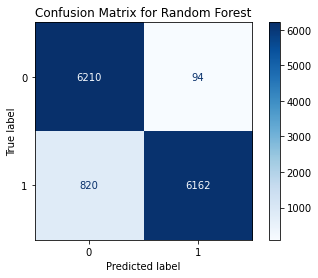

In [ ]:
# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")
plt.title('Confusion Matrix for Random Forest')
# plt.savefig('CM.png', dpi=600) 
plt.show()

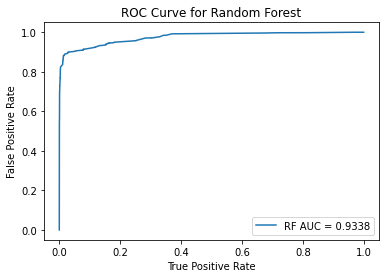

In [ ]:
# Getting false and true positive rate to plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label='RF AUC = '+str(np.round(bin_metrics.areaUnderROC,4)))
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')  
plt.legend(loc='lower right')
# plt.savefig('CM.png', dpi=600) 
plt.show()

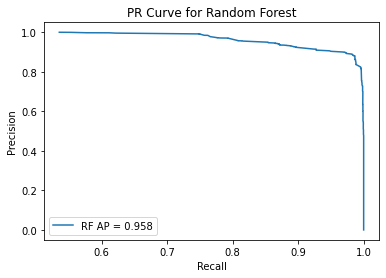

In [ ]:
# Getting precision and recall to plot PR curve
prec, rec, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(prec, rec, label='RF AP = ' + str(np.round(bin_metrics.areaUnderPR,4)))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve for Random Forest') 
plt.legend(loc='lower left')
# plt.savefig('CM.png', dpi=600) 
plt.show()

## **<font color="#FBBF44">3.5 COMPARING CLASSIFIERS</font>**

In [ ]:
model_dt = DecisionTreeClassifier(featuresCol='clf_vector', labelCol='fake').fit(data_train)
model_logreg = LogisticRegression(featuresCol='clf_vector', labelCol='fake').fit(data_train)
model_svc = LinearSVC(featuresCol='clf_vector', labelCol='fake').fit(data_train)
model_rfc = RandomForestClassifier(featuresCol='clf_vector', labelCol='fake').fit(data_train)

models = {
  'Decision Tree': model_dt,
  'Logistic Regression': model_logreg,
  'Support Vector Machine': model_svc,
  'Random Forest': model_rfc,
  }

In [ ]:
y_pred = {}
y_proba = {}
y_test = {}

for name, model in models.items():
  print(name, 'metrics:')
  predictions = model.transform(data_test)

  preds_and_labels = predictions.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                             .withColumn("fake",col("fake").cast('float'))
  metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

  y_pred[name] = predictions.select('prediction').rdd.keys().collect()
  if "proability" in predictions.columns:
    y_proba[name] = predictions.select(vector_to_array("probability")[1]).rdd.keys().collect()
  else:
    y_proba[name] = predictions.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
  y_test[name] = predictions.select("fake").rdd.keys().collect()

  print('Accuracy:', np.round(metrics.accuracy ,4))
  print('Precision:', np.round(metrics.weightedPrecision ,4))
  print('Recall:', np.round(metrics.weightedRecall ,4))
  print('F-score:', np.round(metrics.weightedFMeasure(), 4), '\n')

Decision Tree metrics:


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.9238
Precision: 0.931
Recall: 0.9238
F-score: 0.9237 

Logistic Regression metrics:
Accuracy: 0.9275
Precision: 0.929
Recall: 0.9275
F-score: 0.9276 

Support Vector Machine metrics:
Accuracy: 0.9341
Precision: 0.9363
Recall: 0.9341
F-score: 0.9341 

Random Forest metrics:
Accuracy: 0.9312
Precision: 0.9368
Recall: 0.9312
F-score: 0.9312 



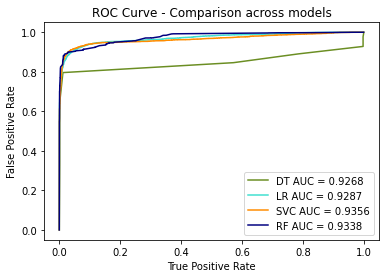

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test['Decision Tree'], y_proba['Decision Tree'])
fpr2, tpr2, thresholds2 = roc_curve(y_test['Logistic Regression'], y_proba['Logistic Regression'])
fpr3, tpr3, thresholds3 = roc_curve(y_test['Support Vector Machine'], y_proba['Support Vector Machine'])
fpr4, tpr4, thresholds4 = roc_curve(y_test['Random Forest'], y_proba['Random Forest'])

plt.plot(fpr, tpr, color='olivedrab', label='DT AUC = ' + 
         str(getAUC(y_test['Decision Tree'], y_pred['Decision Tree'])))
plt.plot(fpr2, tpr2, color='turquoise', label='LR AUC = ' + 
         str(getAUC(y_test['Logistic Regression'], y_pred['Logistic Regression'])))
plt.plot(fpr3, tpr3, color='darkorange', label='SVC AUC = ' + 
         str(getAUC(y_test['Support Vector Machine'], y_pred['Support Vector Machine'])))
plt.plot(fpr4, tpr4, color='navy', label='RF AUC = ' + 
         str(getAUC(y_test['Random Forest'], y_pred['Random Forest'])))
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve - Comparison across models')  
plt.legend(loc='lower right')
plt.savefig('ComparisonModelsROC.png', dpi=600) 
plt.show()

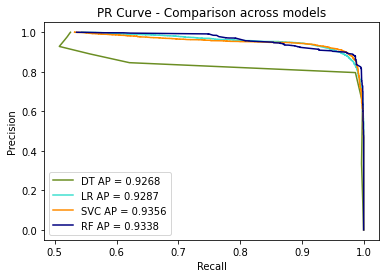

In [ ]:
# Getting precision and recall to plot PR curve
prec, rec, thresholds = precision_recall_curve(y_test['Decision Tree'], y_proba['Decision Tree'])
prec2, rec2, thresholds2 = precision_recall_curve(y_test['Logistic Regression'], y_proba['Logistic Regression'])
prec3, rec3, thresholds3 = precision_recall_curve(y_test['Support Vector Machine'], y_proba['Support Vector Machine'])
prec4, rec4, thresholds4 = precision_recall_curve(y_test['Random Forest'], y_proba['Random Forest'])

plt.plot(prec, rec, color='olivedrab', label='DT AP = ' + 
         str(getAUC(y_test['Decision Tree'], y_pred['Decision Tree'])))
plt.plot(prec2, rec2, color='turquoise', label='LR AP = ' + 
         str(getAUC(y_test['Logistic Regression'], y_pred['Logistic Regression'])))
plt.plot(prec3, rec3, color='darkorange', label='SVC AP = ' + 
         str(getAUC(y_test['Support Vector Machine'], y_pred['Support Vector Machine'])))
plt.plot(prec4, rec4, color='navy', label='RF AP = ' + 
         str(getAUC(y_test['Random Forest'], y_pred['Random Forest'])))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve - Comparison across models') 
plt.legend(loc='lower left')
plt.savefig('ComparisonModelsPR.png', dpi=600) 
plt.show()

## **<font color="#FBBF44">3.6 COMPARING TRAINING VECTORS</font>**

In [ ]:
# Splitting training and testing data
(data_train, data_test) = data_clf.randomSplit([0.7, 0.3], seed = 42)
print('Number of training records: ', data_train.count())
print('Number of testing records: ', data_test.count())
data_test.show(5)

Number of training records:  31567
Number of testing records:  13286
+---------------+--------------------+-------------+------------------+--------------------+----+--------------------+
|titleTokens_vec|      textTokens_vec|  subject_vec|          date_vec|       full_features|fake|          clf_vector|
+---------------+--------------------+-------------+------------------+--------------------+----+--------------------+
|     (88,[],[])|        (3024,[],[])|(6,[1],[1.0])| [2017.0,1.0,20.0]|(3121,[3113,3118,...|   1|(97,[89,94,95,96]...|
|     (88,[],[])|        (3024,[],[])|(6,[2],[1.0])| [2017.0,3.0,30.0]|(3121,[3114,3118,...|   1|(97,[90,94,95,96]...|
|     (88,[],[])|(3024,[0,1,2,3,4,...|(6,[1],[1.0])| [2016.0,1.0,12.0]|(3121,[88,89,90,9...|   1|(97,[89,94,95,96]...|
|     (88,[],[])|(3024,[0,1,2,3,4,...|(6,[2],[1.0])| [2016.0,1.0,12.0]|(3121,[88,89,90,9...|   1|(97,[90,94,95,96]...|
|     (88,[],[])|(3024,[0,1,2,3,4,...|(6,[5],[1.0])|[2017.0,12.0,28.0]|(3121,[88,89,90,9...|   1|(

In [ ]:
model_svc = LinearSVC(featuresCol='clf_vector', labelCol='fake').fit(data_train)
model_svc2 = LinearSVC(featuresCol='titleTokens_vec', labelCol='fake').fit(data_train)
model_svc3 = LinearSVC(featuresCol='textTokens_vec', labelCol='fake').fit(data_train)
model_svc4 = LinearSVC(featuresCol='subject_vec', labelCol='fake').fit(data_train)
model_svc5 = LinearSVC(featuresCol='date_vec', labelCol='fake').fit(data_train)
model_svc6 = LinearSVC(featuresCol='full_features', labelCol='fake').fit(data_train)

models = {
  'SVC': model_svc,
  'SVC2': model_svc2,
  'SVC3': model_svc3,
  'SVC4': model_svc4,
  'SVC5': model_svc5,
  'SVC6': model_svc6,
  }

In [ ]:
y_pred2 = {}
y_proba2 = {}
y_test2 = {}
AUC2 = {}
AP2 = {}

for name, model in models.items():
  print(name, 'metrics')
  predictions = model.transform(data_test)

  preds_and_labels = predictions.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                             .withColumn("fake",col("fake").cast('float'))

  metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

  y_pred2[name] = predictions.select('prediction').rdd.keys().collect()
  if "proability" in predictions.columns:
    y_proba2[name] = predictions.select(vector_to_array("probability")[1]).rdd.keys().collect()
  else:
    y_proba2[name] = predictions.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
  y_test2[name] = predictions.select("fake").rdd.keys().collect()

  print('Accuracy:', np.round(metrics.accuracy ,4))
  print('Precision:', np.round(metrics.weightedPrecision ,4))
  print('Recall:', np.round(metrics.weightedRecall ,4))
  print('F-score:', np.round(metrics.weightedFMeasure(), 4), '\n')

SVC metrics


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.936
Precision: 0.9383
Recall: 0.936
F-score: 0.9361 

SVC2 metrics
Accuracy: 0.8197
Precision: 0.8388
Recall: 0.8197
F-score: 0.8184 

SVC3 metrics
Accuracy: 0.9942
Precision: 0.9942
Recall: 0.9942
F-score: 0.9942 

SVC4 metrics
Accuracy: 0.6225
Precision: 0.6222
Recall: 0.6225
F-score: 0.6191 

SVC5 metrics
Accuracy: 0.6921
Precision: 0.7038
Recall: 0.6921
F-score: 0.6904 

SVC6 metrics
Accuracy: 0.9959
Precision: 0.9959
Recall: 0.9959
F-score: 0.9959 



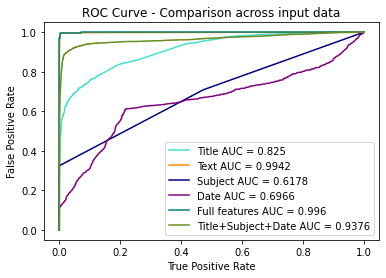

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test2['SVC'], y_proba2['SVC'])
fpr2, tpr2, thresholds2 = roc_curve(y_test2['SVC2'], y_proba2['SVC2'])
fpr3, tpr3, thresholds3 = roc_curve(y_test2['SVC3'], y_proba2['SVC3'])
fpr4, tpr4, thresholds4 = roc_curve(y_test2['SVC4'], y_proba2['SVC4'])
fpr5, tpr5, thresholds5 = roc_curve(y_test2['SVC5'], y_proba2['SVC5'])
fpr6, tpr6, thresholds6 = roc_curve(y_test2['SVC6'], y_proba2['SVC6'])

plt.plot(fpr2, tpr2, color= 'turquoise', label='Title AUC = ' + 
         str(getAUC(y_test2['SVC2'], y_pred2['SVC2'])))
plt.plot(fpr3, tpr3, color= 'darkorange', label='Text AUC = ' + 
         str(getAUC(y_test2['SVC3'], y_pred2['SVC3'])))
plt.plot(fpr4, tpr4, color= 'navy', label='Subject AUC = ' + 
         str(getAUC(y_test2['SVC4'], y_pred2['SVC4'])))
plt.plot(fpr5, tpr5, color= 'purple', label='Date AUC = ' + 
         str(getAUC(y_test2['SVC5'], y_pred2['SVC5'])))
plt.plot(fpr6, tpr6, color= 'teal', label='Full features AUC = ' + 
         str(getAUC(y_test2['SVC6'], y_pred2['SVC6'])))
plt.plot(fpr, tpr, color= 'olivedrab', label='Title+Subject+Date AUC = ' + 
         str(getAUC(y_test2['SVC'], y_pred2['SVC'])))

plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve - Comparison across input data')  
plt.legend(loc='lower right')
plt.savefig('ComparisonDataROC.png', dpi=600) 
plt.show()

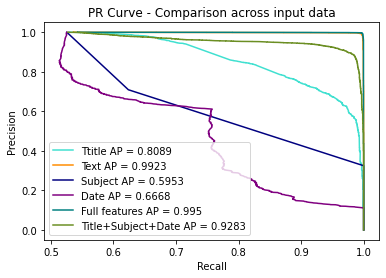

In [ ]:
# Getting precision and recall to plot PR curve
prec, rec, thresholds = precision_recall_curve(y_test2['SVC'], y_proba2['SVC'])
prec2, rec2, thresholds2 = precision_recall_curve(y_test2['SVC2'], y_proba2['SVC2'])
prec3, rec3, thresholds3 = precision_recall_curve(y_test2['SVC3'], y_proba2['SVC3'])
prec4, rec4, thresholds4 = precision_recall_curve(y_test2['SVC4'], y_proba2['SVC4'])
prec5, rec5, thresholds5 = precision_recall_curve(y_test2['SVC5'], y_proba2['SVC5'])
prec6, rec6, thresholds6 = precision_recall_curve(y_test2['SVC6'], y_proba2['SVC6'])

plt.plot(prec2, rec2, color= 'turquoise', label='Ttitle AP = ' + 
         str(getAP(y_test2['SVC2'], y_pred2['SVC2'])))
plt.plot(prec3, rec3, color= 'darkorange', label='Text AP = ' + 
         str(getAP(y_test2['SVC3'], y_pred2['SVC3'])))
plt.plot(prec4, rec4, color= 'navy', label='Subject AP = ' + 
         str(getAP(y_test2['SVC4'], y_pred2['SVC4'])))
plt.plot(prec5, rec5, color= 'purple', label='Date AP = ' + 
         str(getAP(y_test2['SVC5'], y_pred2['SVC5'])))
plt.plot(prec6, rec6, color= 'teal', label='Full features AP = ' + 
         str(getAP(y_test2['SVC6'], y_pred2['SVC6'])))
plt.plot(prec, rec, color= 'olivedrab', label='Title+Subject+Date AP = ' + 
         str(getAP(y_test2['SVC'], y_pred2['SVC'])))
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve - Comparison across input data') 
plt.legend(loc='lower left')
plt.savefig('ComparisonDataPR.png', dpi=600) 
plt.show()

## **<font color="#FBBF44">3.7 PARAMETER HYPERTUNING</font>**

In [ ]:
# Splitting training and testing data
(data_train, data_test) = data_clf.select('clf_vector','fake').randomSplit([0.7, 0.3], seed = 42)
print('Number of training records: ', data_train.count())
print('Number of testing records: ', data_test.count())
data_test.show(5)

Number of training records:  31567
Number of testing records:  13286
+--------------------+----+
|          clf_vector|fake|
+--------------------+----+
|(97,[0,1,2,4,12,4...|   1|
|(97,[0,1,2,11,36,...|   1|
|(97,[0,1,2,14,38,...|   1|
|(97,[0,1,2,14,38,...|   1|
|(97,[0,1,2,29,88,...|   1|
+--------------------+----+
only showing top 5 rows



In [ ]:
dt = DecisionTreeClassifier(labelCol = "fake", featuresCol = "clf_vector")
lr = LogisticRegression(labelCol = "fake", featuresCol = "clf_vector")
svc = LinearSVC(labelCol = "fake", featuresCol = "clf_vector")
rf = RandomForestClassifier(labelCol = "fake", featuresCol = "clf_vector")

paramGrid_dt = ParamGridBuilder() \
              .addGrid(dt.maxDepth, [5,15,25]) \
              .addGrid(dt.maxBins, [10,30,50]) \
              .build()
  
paramGrid_lr = ParamGridBuilder() \
              .addGrid(lr.regParam, [.01,.1,1,10]) \
              .addGrid(lr.fitIntercept, [True, False]) \
              .addGrid(lr.elasticNetParam, [.01,.05,.1,.5]) \
              .addGrid(lr.maxIter, [100, 200, 300]) \
              .build()

paramGrid_svc = ParamGridBuilder() \
                .addGrid(svc.regParam, [.01,.1,1,10]) \
                .addGrid(svc.fitIntercept, [True, False]) \
                .addGrid(svc.standardization, [True, False]) \
                .addGrid(svc.maxIter, [100, 200, 300]) \
                .build()
  
paramGrid_rf = ParamGridBuilder() \
              .addGrid(rf.numTrees, [30,40,50,60]) \
              .addGrid(rf.maxDepth, [5,15,25,30]) \
              .build()

crossval_dt = CrossValidator(estimator = dt,
                             estimatorParamMaps = paramGrid_dt,
                             evaluator = BinaryClassificationEvaluator(labelCol = 'fake'),
                             seed = 42,
                             numFolds=5)

crossval_lr = CrossValidator(estimator = lr,
                             estimatorParamMaps = paramGrid_lr,
                             evaluator = BinaryClassificationEvaluator(labelCol = 'fake'),
                             seed = 42,
                             numFolds=5)

crossval_svc = CrossValidator(estimator = svc,
                              estimatorParamMaps = paramGrid_svc,
                              evaluator = BinaryClassificationEvaluator(labelCol = 'fake'),
                              seed = 42,
                              numFolds=5)

crossval_rf = CrossValidator(estimator = rf,
                             estimatorParamMaps = paramGrid_rf,
                             evaluator = BinaryClassificationEvaluator(labelCol = 'fake'),
                             seed = 42,
                             numFolds=5)

**<font color="#ffff7">DECISION TREE</font>**

In [ ]:
cv_dt = crossval_dt.fit(data_train)
predictions_dt = cv_dt.transform(data_test)
predictions_dt.show(5)

+--------------------+----+-------------+-----------+----------+
|          clf_vector|fake|rawPrediction|probability|prediction|
+--------------------+----+-------------+-----------+----------+
|(97,[0,1,2,4,12,4...|   1|   [0.0,78.0]|  [0.0,1.0]|       1.0|
|(97,[0,1,2,11,36,...|   1|   [0.0,78.0]|  [0.0,1.0]|       1.0|
|(97,[0,1,2,14,38,...|   1|    [0.0,1.0]|  [0.0,1.0]|       1.0|
|(97,[0,1,2,14,38,...|   1|    [0.0,1.0]|  [0.0,1.0]|       1.0|
|(97,[0,1,2,29,88,...|   1|   [0.0,78.0]|  [0.0,1.0]|       1.0|
+--------------------+----+-------------+-----------+----------+
only showing top 5 rows



In [ ]:
preds_and_labels_dt = predictions_dt.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                           .withColumn("fake",col("fake").cast('float'))

bin_metrics_dt = BinaryClassificationMetrics(preds_and_labels_dt.rdd.map(tuple))                                     
metrics_dt = MulticlassMetrics(preds_and_labels_dt.rdd.map(tuple))

y_pred_dt = predictions_dt.select('prediction').rdd.keys().collect()
y_proba_dt = predictions_dt.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_test_dt = predictions_dt.select("fake").rdd.keys().collect()
print('Accuracy:', np.round(metrics_dt.accuracy ,4))
print('Precision:', np.round(metrics_dt.weightedPrecision ,4))
print('Recall:', np.round(metrics_dt.weightedRecall ,4))
print('F-score:', np.round(metrics_dt.weightedFMeasure(), 4))
print('AUC:', np.round(bin_metrics_dt.areaUnderROC ,4))
print('AP:', np.round(bin_metrics_dt.areaUnderPR ,4))  

cv_dt.bestModel

Accuracy: 0.9483
Precision: 0.95
Recall: 0.9483
F-score: 0.9483
AUC: 0.9497
AP: 0.9603


DecisionTreeClassificationModel: uid=DecisionTreeClassifier_604a66b53c34, depth=25, numNodes=1469, numClasses=2, numFeatures=97

**<font color="#ffff7">LOGISTIC REGRESSION</font>**

In [ ]:
cv_lr = crossval_lr.fit(data_train)
predictions_lr = cv_lr.transform(data_test)
predictions_lr.show(5)

+--------------------+----+--------------------+--------------------+----------+
|          clf_vector|fake|       rawPrediction|         probability|prediction|
+--------------------+----+--------------------+--------------------+----------+
|(97,[0,1,2,4,12,4...|   1|[-1.8387299999503...|[0.13720156248671...|       1.0|
|(97,[0,1,2,11,36,...|   1|[0.05923038488208...|[0.51480326869046...|       0.0|
|(97,[0,1,2,14,38,...|   1|[-4.7536360910844...|[0.00854661960133...|       1.0|
|(97,[0,1,2,14,38,...|   1|[-8.9862431758592...|[1.25103609586948...|       1.0|
|(97,[0,1,2,29,88,...|   1|[-3.8848978598798...|[0.02013613157967...|       1.0|
+--------------------+----+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
preds_and_labels_lr = predictions_lr.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                           .withColumn("fake",col("fake").cast('float'))

bin_metrics_lr = BinaryClassificationMetrics(preds_and_labels_lr.rdd.map(tuple))                                     
metrics_lr = MulticlassMetrics(preds_and_labels_lr.rdd.map(tuple))

y_pred_lr = predictions_lr.select('prediction').rdd.keys().collect()
y_proba_lr = predictions_lr.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_test_lr = predictions_lr.select("fake").rdd.keys().collect()
print('Accuracy:', np.round(metrics_lr.accuracy ,4))
print('Precision:', np.round(metrics_lr.weightedPrecision ,4))
print('Recall:', np.round(metrics_lr.weightedRecall ,4))
print('F-score:', np.round(metrics_lr.weightedFMeasure(), 4))
print('AUC:', np.round(bin_metrics_lr.areaUnderROC ,4))
print('AP:', np.round(bin_metrics_lr.areaUnderPR ,4))  

cv_lr.bestModel

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.9225
Precision: 0.9245
Recall: 0.9225
F-score: 0.9225
AUC: 0.9239
AP: 0.9316


LogisticRegressionModel: uid=LogisticRegression_cc952a9e3afa, numClasses=2, numFeatures=97

**<font color="#ffff7">SUPPORT VECTOR MACHINES</font>**

In [ ]:
cv_svc = crossval_svc.fit(data_train)
predictions_svc = cv_svc.transform(data_test)
predictions_svc.show(5)

+--------------------+----+--------------------+----------+
|          clf_vector|fake|       rawPrediction|prediction|
+--------------------+----+--------------------+----------+
|(97,[0,1,2,4,12,4...|   1|[-0.8020266643457...|       1.0|
|(97,[0,1,2,11,36,...|   1|[0.15726171166397...|       0.0|
|(97,[0,1,2,14,38,...|   1|[-2.2963921587193...|       1.0|
|(97,[0,1,2,14,38,...|   1|[-4.2376671373631...|       1.0|
|(97,[0,1,2,29,88,...|   1|[-1.7975925025994...|       1.0|
+--------------------+----+--------------------+----------+
only showing top 5 rows



In [ ]:
preds_and_labels_svc = predictions_svc.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                           .withColumn("fake",col("fake").cast('float'))

bin_metrics_svc = BinaryClassificationMetrics(preds_and_labels_svc.rdd.map(tuple))                                     
metrics_svc = MulticlassMetrics(preds_and_labels_svc.rdd.map(tuple))

y_pred_svc = predictions_svc.select('prediction').rdd.keys().collect()
y_proba_svc = predictions_svc.select(vector_to_array("rawPrediction")[1]).rdd.keys().collect()
y_test_svc = predictions_svc.select("fake").rdd.keys().collect()
print('Accuracy:', np.round(metrics_svc.accuracy ,4))
print('Precision:', np.round(metrics_svc.weightedPrecision ,4))
print('Recall:', np.round(metrics_svc.weightedRecall ,4))
print('F-score:', np.round(metrics_svc.weightedFMeasure(), 4))
print('AUC:', np.round(bin_metrics_svc.areaUnderROC ,4))
print('AP:', np.round(bin_metrics_svc.areaUnderPR ,4))  

cv_svc.bestModel

Accuracy: 0.9152
Precision: 0.921
Recall: 0.9152
F-score: 0.9152
AUC: 0.9179
AP: 0.9398


LinearSVCModel: uid=LinearSVC_bd4fc4335a6a, numClasses=2, numFeatures=97

**<font color="#ffff7">RANDOM FORESTS</font>**

In [ ]:
cv_rf = crossval_rf.fit(data_train)
predictions_rf = cv_rf.transform(data_test)
predictions_rf.show(5)

+--------------------+----+--------------------+--------------------+----------+
|          clf_vector|fake|       rawPrediction|         probability|prediction|
+--------------------+----+--------------------+--------------------+----------+
|(97,[0,1,2,4,12,4...|   1|[12.2957339805866...|[0.24591467961173...|       1.0|
|(97,[0,1,2,11,36,...|   1|[5.79452004360091...|[0.11589040087201...|       1.0|
|(97,[0,1,2,14,38,...|   1|[8.61089977591247...|[0.17221799551824...|       1.0|
|(97,[0,1,2,14,38,...|   1|[2.22320153132455...|[0.04446403062649...|       1.0|
|(97,[0,1,2,29,88,...|   1|[3.19053094345557...|[0.06381061886911...|       1.0|
+--------------------+----+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
preds_and_labels_rf = predictions_rf.select('prediction', 'fake').withColumn("prediction",col("prediction").cast('float')) \
                                                           .withColumn("fake",col("fake").cast('float'))

bin_metrics_rf = BinaryClassificationMetrics(preds_and_labels_rf.rdd.map(tuple))                                     
metrics_rf = MulticlassMetrics(preds_and_labels_rf.rdd.map(tuple))

y_pred_rf = predictions_rf.select('prediction').rdd.keys().collect()
y_proba_rf = predictions_rf.select(vector_to_array("probability")[1]).rdd.keys().collect()
y_test_rf = predictions_rf.select("fake").rdd.keys().collect()
print('Accuracy:', np.round(metrics_rf.accuracy ,4))
print('Precision:', np.round(metrics_rf.weightedPrecision ,4))
print('Recall:', np.round(metrics_rf.weightedRecall ,4))
print('F-score:', np.round(metrics_rf.weightedFMeasure(), 4))
print('AUC:', np.round(bin_metrics_rf.areaUnderROC ,4))
print('AP:', np.round(bin_metrics_rf.areaUnderPR ,4))  

cv_rf.bestModel

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Accuracy: 0.9552
Precision: 0.9572
Recall: 0.9552
F-score: 0.9552
AUC: 0.9567
AP: 0.9702


RandomForestClassificationModel: uid=RandomForestClassifier_6aa7bbfc41e8, numTrees=50, numClasses=2, numFeatures=97

# **<font color="#34ebdb">4.0 FREQUENT PATTERN MINING</font>**

In [36]:
# Removing numbers and symbols to remain only with words
new_data = fake_data.withColumn("text",regexp_replace(col('text'), '\d+', ''))

# Tokenizer
regex_tokenizer = RegexTokenizer(inputCol="text", outputCol="regToken", pattern="\\W")
new_data = regex_tokenizer.transform(new_data)

# Removing stopwords
remover = StopWordsRemover(inputCol="regToken", outputCol="tokens")
new_data = remover.transform(new_data)
data_fpm = new_data.select("tokens")
data_fpm.show(5)

+--------------------+
|              tokens|
+--------------------+
|[donald, trump, c...|
|[house, intellige...|
|[friday, revealed...|
|[christmas, day, ...|
|[pope, francis, u...|
+--------------------+
only showing top 5 rows



In [37]:
# Obtaining unique items per observation
un_pre = [data[0] for data in data_fpm.select('tokens').collect()]
unique_val = []
num = 0
for x in un_pre:
  unique_val.append((num,list(set(x))))
  num += 1

In [38]:
df = spark.createDataFrame(unique_val, ["id", "items"])

fpGrowth = FPGrowth(itemsCol="items", minSupport=0.25, minConfidence=0.6)
model = fpGrowth.fit(df)

# Display frequent itemsets.
model.freqItemsets.show(10)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------------+-----+
|       items| freq|
+------------+-----+
|     [white]| 5935|
|      [also]| 8993|
|[also, said]| 5929|
|   [america]| 6230|
|       [one]|12319|
|[one, trump]| 7117|
| [one, said]| 7798|
|      [know]| 6552|
|      [news]| 7181|
|       [via]|11246|
+------------+-----+
only showing top 10 rows



In [39]:
# Display generated association rules.
model.associationRules.show(10)

+----------+-----------+------------------+------------------+-------------------+
|antecedent| consequent|        confidence|              lift|            support|
+----------+-----------+------------------+------------------+-------------------+
|    [like]|      [one]| 0.631547736706859| 1.203267873061668|0.27225086276681865|
|    [like]|    [trump]|0.6058509586874876|1.1355048990939889|0.26117336287333304|
|    [like]|   [people]|0.6127693220003954|1.2579645549436962| 0.2641557666908099|
|    [like]|     [said]| 0.613757659616525|1.1271913950594254|0.26458182437902095|
|   [trump]|[president]|  0.61151481274455|1.3627861915996329| 0.3262749776319714|
|   [trump]|   [donald]|0.7249061726423381|1.8647821983875843|0.38677516935793105|
|     [via]|      [one]|0.6216432509336653| 1.184397170441112|0.29785692982829876|
|     [via]|     [said]|0.6436066156855771|1.1820102407477449|0.30838055472711007|
|     [via]| [featured]|0.6219989329539392|1.7203555214897368| 0.2980273529035831|
|   

In [40]:
# transform examines the input items against all the association rules and summarize the consequents as prediction
model.transform(df).show(10)

+---+--------------------+--------------------+
| id|               items|          prediction|
+---+--------------------+--------------------+
|  0|[twitter, wendy, ...|              [said]|
|  1|[isn, president, ...|[one, people, don...|
|  2|[twitter, deplane...|   [said, president]|
|  3|[serve, number, t...|         [one, said]|
|  4|[environmental, w...|         [president]|
|  5|[number, needs, s...|  [one, said, trump]|
|  6|[twitter, deleted...|              [said]|
|  7|[looked, fully, a...|         [one, said]|
|  8|[beyond, senate, ...|              [said]|
|  9|[stroke, kinds, s...|         [one, said]|
+---+--------------------+--------------------+
only showing top 10 rows



In [41]:
# checking for same consequent in the association rules
ass_rules_con = [data[0] for data in model.associationRules.select('consequent').collect()]

# creating a dictionary to count the occurence of the same world in the consequent of the association rules
dict_rules_con = {}
for x in ass_rules_con:
  k = tuple(x)
  if k not in dict_rules_con.keys():
    dict_rules_con[k] = 1
  else:
    dict_rules_con[k] += 1
#print(dict_rules_con)

In [42]:
# checking for same antecedent in the association rules
ass_rules_ant = [data[0] for data in model.associationRules.select('antecedent').collect()]

# number of association rules found with a minumum support of 0,25
print(len(ass_rules_ant))

#creating a dictionary to count the occurence of the same world in the antecedent of the association rules
dict_rules = {}
for x in ass_rules_ant:
  k = tuple(x)
  if k not in dict_rules.keys():
    dict_rules[k] = 1
  else:
    dict_rules[k] += 1
#print(dict_rules)

31


In [43]:
# checking for the top ten of frequent items
freq_item_data = [data[0] for data in model.freqItemsets.select('items').collect()] 
freq_item = [data[0] for data in model.freqItemsets.select('freq').collect()] 

sort_freq = sorted(freq_item)[len(freq_item)-10:]

most_used_item = []

for i in range(len(freq_item)):
  if freq_item[i] in sort_freq:
    most_used_item.append(freq_item_data[i])

#print(most_used_item)

In [ ]:
# checking for model with different minSup [0.05,0.95]
c = 0.05
for x in range(18):
  print("Modello con minSup a {}\n".format(c))
  fpGrowth = FPGrowth(itemsCol="items", minSupport=c, minConfidence=0.6)
  c += 0.05
  model = fpGrowth.fit(df)

  # Display frequent itemsets.
  model.freqItemsets.show()

  # Display generated association rules.
  model.associationRules.show()

  # transform examines the input items against all the association rules and summarize the
  # consequents as prediction
  model.transform(df).show()

Modello con minSup a 0.1



/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+--------------+----+
|         items|freq|
+--------------+----+
|      [person]|2972|
|     [working]|2420|
|           [m]|3901|
|      [m, one]|2490|
|   [m, people]|2426|
|     [m, said]|2758|
|     [history]|2580|
|      [enough]|2694|
|       [clear]|2828|
|        [long]|3614|
|   [long, one]|2457|
|  [long, said]|2369|
|     [believe]|3241|
|        [need]|3694|
|   [need, one]|2416|
|[need, people]|2423|
|        [used]|3295|
|         [fox]|2621|
|  [department]|2755|
|      [public]|4035|
+--------------+----+
only showing top 20 rows

+--------------------+----------+------------------+------------------+-------------------+
|          antecedent|consequent|        confidence|              lift|            support|
+--------------------+----------+------------------+------------------+-------------------+
|[image, via, peop...|[featured]|0.9588957055214724| 2.652161336824709|0.13318563333475353|
|[image, via, peop...|  [donald]|0.8429447852760736|2.1684301901813594|0.11708